## 1. Install and Import Dependencies

If dependencies are not installed, run first:
```
pip install diffusers transformers accelerate datasets
```

In [1]:
import os
import subprocess

def get_least_used_gpu():
    """Dynamically select the GPU with lowest utilization"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=index,utilization.gpu,memory.used', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        
        gpus = []
        for line in result.stdout.strip().split('\n'):
            parts = line.split(', ')
            if len(parts) >= 3:
                idx = int(parts[0])
                util = int(parts[1])
                mem = int(parts[2])
                gpus.append((idx, util, mem))
                print(f"  GPU {idx}: {util}% utilization, {mem} MiB memory used")
        
        if gpus:
            # Sort by utilization first, then by memory used
            gpus.sort(key=lambda x: (x[1], x[2]))
            best_gpu = gpus[0][0]
            print(f"\n✓ Selected GPU {best_gpu} (lowest utilization)")
            return str(best_gpu)
    except Exception as e:
        print(f"Warning: Could not query GPUs: {e}")
    
    return "0"  # Default to GPU 0

print("=== Selecting GPU with lowest utilization ===")
selected_gpu = get_least_used_gpu()
os.environ["CUDA_VISIBLE_DEVICES"] = selected_gpu
print(f"Set CUDA_VISIBLE_DEVICES = {selected_gpu}")

=== Selecting GPU with lowest utilization ===
  GPU 0: 0% utilization, 1 MiB memory used

✓ Selected GPU 0 (lowest utilization)
Set CUDA_VISIBLE_DEVICES = 0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os

# Add project directory to sys.path to find custom modules
project_dir = "/workspace/kswgd"
if project_dir not in sys.path:
    sys.path.append(project_dir)
    print(f"Added {project_dir} to sys.path")

# Check GPU
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"    Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.1f} GB")

Added /workspace/kswgd to sys.path
CUDA available: True
Number of GPUs: 1
  GPU 0: NVIDIA A100-SXM4-80GB
    Memory: 85.1 GB


## 2. Download and Load CelebA-HQ Dataset

We load the CelebA-HQ dataset first. This dataset serves as the **Target Distribution** for KSWGD and the **Ground Truth** for LDM's evaluation (FID). By loading it here, we ensure both methods are compared against the same data source.

In [3]:
# Download CelebA-HQ to data/ folder
import subprocess
import sys
import os

try:
    from datasets import load_dataset
except ImportError:
    print("Installing datasets library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "datasets", "-q"])
    from datasets import load_dataset

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# Set data directory (alongside MNIST, CIFAR-10)
DATA_DIR = "/workspace/kswgd/data"
CELEBAHQ_CACHE = os.path.join(DATA_DIR, "CelebA-HQ")
os.makedirs(CELEBAHQ_CACHE, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"CelebA-HQ cache directory: {CELEBAHQ_CACHE}")

# Download CelebA-HQ dataset to data/ folder
# Try multiple possible dataset sources
print("\nDownloading CelebA-HQ dataset...")
print("Data will be saved to data/CelebA-HQ/ folder")

dataset_sources = [
    "mattymchen/celeba-hq",           # Alternative source 1
    "datasets-community/CelebA-HQ",   # Alternative source 2
    "xinrongzhang2022/celeba-hq",     # Alternative source 3
]

celebahq_dataset = None
for source in dataset_sources:
    try:
        print(f"Trying to load: {source}")
        celebahq_dataset = load_dataset(
            source, 
            split="train",
            cache_dir=CELEBAHQ_CACHE,
            trust_remote_code=True
        )
        print(f"✓ Successfully loaded: {source}")
        break
    except Exception as e:
        print(f"✗ Failed to load: {e}")
        continue

if celebahq_dataset is None:
    raise RuntimeError("Unable to load CelebA-HQ dataset, please check network connection or download manually")

print(f"\n✓ CelebA-HQ loaded!")
print(f"  Save location: {CELEBAHQ_CACHE}")
print(f"  Total available samples: {len(celebahq_dataset)}")

/workspace/kswgd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'mattymchen/celeba-hq' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Data directory: /workspace/kswgd/data
CelebA-HQ cache directory: /workspace/kswgd/data/CelebA-HQ

Data will be saved to data/CelebA-HQ/ folder
Trying to load: mattymchen/celeba-hq
✓ Successfully loaded: mattymchen/celeba-hq

✓ CelebA-HQ loaded!
  Save location: /workspace/kswgd/data/CelebA-HQ
  Total available samples: 28000


## 3. Load Pretrained Unconditional Latent Diffusion Model

Using `CompVis/ldm-celebahq-256`, an **unconditional** Latent Diffusion Model (LDM) trained on CelebA-HQ.

**LDM Architecture:**
- VAE: Image ↔ Latent Space
- UNet: Denoising in Latent Space (unconditional)

In [4]:
from diffusers import DiffusionPipeline

# Load Unconditional Latent Diffusion Model (LDM)
# This is a true unconditional model working in latent space
print("Loading Unconditional LDM (CompVis/ldm-celebahq-256)...")
print("This is an unconditional Latent Diffusion Model trained on CelebA-HQ")

ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
ldm_pipe = ldm_pipe.to("cuda")  # Use selected GPU

# Fix VQ-VAE scaling factor for proper image generation
# The default scaling_factor may cause color/brightness issues
ldm_pipe.vqvae.config.scaling_factor = 1.0

print("\n✓ Unconditional LDM loaded!")
print(f"  Model: CompVis/ldm-celebahq-256")
print(f"  Output size: 256×256")
print(f"  Latent Space: Yes (VAE)")
print(f"  VAE scaling factor: {ldm_pipe.vqvae.config.scaling_factor}")
print(f"  Generation: Pure unconditional, no condition input required")

Loading Unconditional LDM (CompVis/ldm-celebahq-256)...
This is an unconditional Latent Diffusion Model trained on CelebA-HQ


Loading pipeline components...:  33%|███▎      | 1/3 [00:00<00:00,  6.07it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  67%|██████▋   | 2/3 [00:00<00:00,  3.51it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae.
Defaulting to unsafe serialization. Pass `all


✓ Unconditional LDM loaded!
  Model: CompVis/ldm-celebahq-256
  Output size: 256×256
  Latent Space: Yes (VAE)
  VAE scaling factor: 1.0
  Generation: Pure unconditional, no condition input required


## 3.1 Extract LDM's VAE

Directly use LDM's built-in VAE to maintain consistent latent space. The VAE is pre-trained as part of the LDM, so we demonstrate its reconstruction quality here before proceeding with image generation.

In [5]:
# Directly use LDM's built-in VAE
# This way KSWGD and LDM use exactly the same latent space

print("Extracting LDM's VAE...")

# LDM pipeline contains vqvae (VQ-VAE)
vae = ldm_pipe.vqvae
vae_scaling = 1.0  # LDM's VQ-VAE doesn't need extra scaling

print(f"\n✓ VAE extracted!")
print(f"  Source: LDM's built-in VQ-VAE")
print(f"  Scaling factor: {vae_scaling}")
print(f"  Advantage: KSWGD and LDM share the same latent space")

# VAE helper functions
def _to_vae_range(x):
    """[0,1] → [-1,1]"""
    return (x * 2.0) - 1.0

def _from_vae_range(x):
    """[-1,1] → [0,1]"""
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use selected GPU

Extracting LDM's VAE...

✓ VAE extracted!
  Source: LDM's built-in VQ-VAE
  Scaling factor: 1.0
  Advantage: KSWGD and LDM share the same latent space


=== VAE Reconstruction Quality Test ===

Dataset size: 28000 CelebA-HQ images
Test samples: 5
Sampling method: Random sampling
VAE source: LDM pretrained model built-in VQ-VAE
Test purpose: Validate VAE encode→decode reconstruction quality

Using pure random (no seed)
Randomly selected sample indices: [21178, 18459, 18757, 18947, 6605]


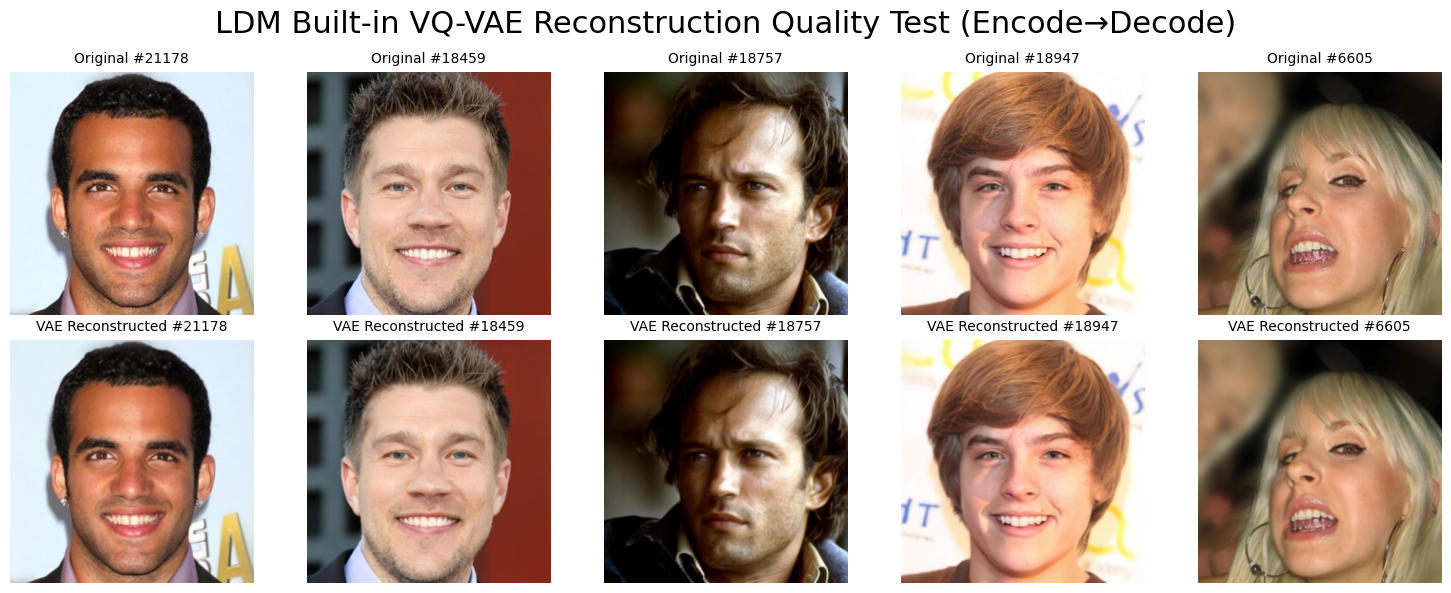

VAE reconstruction test completed.


In [6]:
# Test VAE reconstruction on real images
# 🔍 VAE Quality Test: Demonstrate LDM's built-in VQ-VAE reconstruction capability
# VAE Source: Built-in VQ-VAE from CompVis/ldm-celebahq-256 pretrained model

import random

# ============== Sampling Settings ==============
n_recon = 5
USE_RANDOM_SAMPLES = True  # True: random sampling, False: first n_recon samples
# RANDOM_SEED = 42  # Set random seed for reproducible results (comment out for pure random)
# ==============================================

print(f"=== VAE Reconstruction Quality Test ===\n")
print(f"Dataset size: {len(celebahq_dataset)} CelebA-HQ images")
print(f"Test samples: {n_recon}")
print(f"Sampling method: {'Random sampling' if USE_RANDOM_SAMPLES else 'First '+str(n_recon)+' samples'}")
print(f"VAE source: LDM pretrained model built-in VQ-VAE")
print(f"Test purpose: Validate VAE encode→decode reconstruction quality\n")

# Select test samples
if USE_RANDOM_SAMPLES:
    # Check if RANDOM_SEED is defined, if not use pure random
    if 'RANDOM_SEED' in locals():
        random.seed(RANDOM_SEED)
        print(f"Using random seed: {RANDOM_SEED}")
    else:
        print("Using pure random (no seed)")
    
    test_indices = random.sample(range(len(celebahq_dataset)), n_recon)
    print(f"Randomly selected sample indices: {test_indices}")
else:
    test_indices = list(range(n_recon))
    print(f"Fixed sample indices: {test_indices}")

fig, axes = plt.subplots(2, n_recon, figsize=(15, 6))

vae.eval()
with torch.no_grad():
    for plot_idx, sample_idx in enumerate(test_indices):
        # Original
        img = celebahq_dataset[sample_idx]["image"]
        img_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])(img).unsqueeze(0).to(device)
        
        # Encode & Decode
        latent = vae.encode(_to_vae_range(img_tensor))
        
        if hasattr(latent, 'latents'):
            latent_code = latent.latents
        elif hasattr(latent, 'latent_dist'):
            latent_code = latent.latent_dist.mode()
        else:
            latent_code = latent[0] if isinstance(latent, tuple) else latent
            
        recon = vae.decode(latent_code).sample
        recon_img = _from_vae_range(recon).cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        # Plot
        axes[0, plot_idx].imshow(np.array(img.resize((256, 256))))
        axes[0, plot_idx].set_title(f"Original #{sample_idx}", fontsize=10)
        axes[0, plot_idx].axis('off')
        
        axes[1, plot_idx].imshow(recon_img)
        axes[1, plot_idx].set_title(f"VAE Reconstructed #{sample_idx}", fontsize=10)
        axes[1, plot_idx].axis('off')

plt.suptitle("LDM Built-in VQ-VAE Reconstruction Quality Test (Encode→Decode)", fontsize=22)
plt.tight_layout()
plt.show()

print("VAE reconstruction test completed.")

## 4. Super-Resolution Setup (Real-ESRGAN + GFPGAN)

Set up the upscaling pipeline. Actual LDM generation will happen **after KSWGD** to optimize memory usage.

In [7]:
# ============== Real-ESRGAN + GFPGAN Super-Resolution Setup ==============
import os
import cv2
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from gfpgan import GFPGANer

# Create figures directory if not exists
os.makedirs('/workspace/kswgd/figures', exist_ok=True)

print("Using single GPU mode for upscaling")

# Initialize Real-ESRGAN and GFPGAN
model_path = '/workspace/kswgd/weights/RealESRGAN_x4plus.pth'
gfpgan_path = '/workspace/kswgd/weights/GFPGANv1.3.pth'

print("Initializing Real-ESRGAN + GFPGAN...")
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=200,
    tile_pad=10,
    pre_pad=0,
    half=False,
    gpu_id=0  # Uses the GPU exposed by CUDA_VISIBLE_DEVICES
)
face_enhancer = GFPGANer(
    model_path=gfpgan_path,
    upscale=4,
    arch='clean',
    channel_multiplier=2,
    bg_upsampler=upsampler
)
print("  ✓ Real-ESRGAN + GFPGAN initialized")

def preprocess_image(img_bgr, use_gaussian=True, use_bilateral=True, use_color_norm=True):
    """Apply preprocessing before GFPGAN"""
    processed = img_bgr.copy().astype(np.float32)
    if use_gaussian:
        processed = cv2.GaussianBlur(processed, (3, 3), sigmaX=0.5)
    if use_bilateral:
        processed = cv2.bilateralFilter(processed.astype(np.uint8), d=5, sigmaColor=30, sigmaSpace=30).astype(np.float32)
    if use_color_norm:
        mean_b, mean_g, mean_r = np.mean(processed[:, :, 0]), np.mean(processed[:, :, 1]), np.mean(processed[:, :, 2])
        target_mean, alpha = 127.5, 0.15
        processed[:, :, 0] += alpha * (target_mean - mean_b)
        processed[:, :, 1] += alpha * (target_mean - mean_g)
        processed[:, :, 2] += alpha * (target_mean - mean_r)
        processed = np.clip(processed, 0, 255)
    return processed.astype(np.uint8)

def process_single_image(img, use_face_enhance=True, use_preprocess=False):
    """Process a single image"""
    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        if img.ndim == 3 and img.shape[0] == 3:
            img_np = np.transpose(img, (1, 2, 0))
        else:
            img_np = img
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)

    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    if use_preprocess:
        img_bgr = preprocess_image(img_bgr)

    if use_face_enhance:
        _, _, output_bgr = face_enhancer.enhance(img_bgr, has_aligned=False, only_center_face=False, paste_back=True)
    else:
        output_bgr, _ = upsampler.enhance(img_bgr, outscale=4)

    return cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)

def upscale_images(images_list, use_face_enhance=True, use_preprocess=False, desc="Upscaling"):
    """Upscale images using GFPGAN or Real-ESRGAN"""
    return [process_single_image(img, use_face_enhance, use_preprocess) for img in tqdm(images_list, desc=desc)]

print("✓ Upscaling functions ready")


Using single GPU mode for upscaling
Initializing Real-ESRGAN + GFPGAN...


/workspace/kswgd_env/lib/python3.11/site-packages/realesrgan/utils.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path, map_location=torch.d

  ✓ Real-ESRGAN + GFPGAN initialized
✓ Upscaling functions ready


In [8]:
# Section 6.5: Memory Cleanup
# To avoid OOM during KSWGD, we release the LDM UNet and other components that are no longer needed.
import gc

print(f"GPU Memory before cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

if 'ldm_pipe' in globals():
    # We only need the VAE for KSWGD, so we can release the UNet (the largest part)
    # This can free up 2-4 GB of VRAM.
    print("Releasing LDM UNet and other components...")
    if hasattr(ldm_pipe, 'unet'):
        ldm_pipe.unet = None
    if hasattr(ldm_pipe, 'text_encoder'):
        ldm_pipe.text_encoder = None
    if hasattr(ldm_pipe, 'scheduler'):
        ldm_pipe.scheduler = None
    
gc.collect()
torch.cuda.empty_cache()

print(f"GPU Memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

GPU Memory before cleanup: 1.96 GB
Releasing LDM UNet and other components...
GPU Memory after cleanup: 0.85 GB


## 7. KSWGD Unconditional Generation (Core Experiment)

Using KSWGD (Koopman Spectral Wasserstein Gradient Descent) to perform **unconditional** particle transport generation in latent space.

**Unconditional Pipeline:**
```
Training Data (CelebA-HQ) → VAE Encoder → Latent Z_tar (Target Distribution Samples)
                                              ↓
Random Noise N(0,1) → KSWGD Transport → Z_gen (Unconditional Generation)
                                              ↓
                                   VAE Decoder → Generated Image
```

**Comparison of Two Unconditional Methods (Fair Comparison, Same Dataset):**
| | LDM (Section 2-4) | KSWGD (Section 7) |
|---|---|---|
| Dataset | CelebA-HQ | CelebA-HQ |
| Generation Process | Random Noise → Denoising | Random Noise → KSWGD |
| Core Component | UNet | Kernel & Koopman Matrix + Eigendecomposition |
| Iteration Steps | 200 | Adjustable (e.g., 300) |

In [9]:
# Import KSWGD required libraries and custom kernel functions
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange

# Import your kernel functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

# Try to import GPU version
try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_KSWGD = True
    print("✓ GPU KSWGD backend available (CuPy)")
except Exception as e:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_KSWGD = False
    print(f"✗ GPU KSWGD backend not available: {e}")
    print("  Using CPU backend instead")



✓ GPU KSWGD backend available (CuPy)


In [10]:
# Encode CelebA-HQ images and compress with MLP AutoEncoder
from torchvision import transforms as T
from tqdm.auto import tqdm
import pickle
import os

# Image preprocessing
transform_celebahq = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# ============== MLP Latent Compression Settings ==============
# Use MLP AutoEncoder to compress VAE's 1024-dim latent to lower dimension
REDUCED_DIM = 16  # Target dimension for MLP compression (optimized for background quality)
# =============================================================

# ============== Caching Settings ==============
LOAD_FROM_CACHE = True
CACHE_DIR = "/workspace/kswgd/cache"
os.makedirs(CACHE_DIR, exist_ok=True)
# ==============================================

# ============== MLP Latent AutoEncoder ==============
class LatentAutoEncoder(torch.nn.Module):
    """
    Deeper and wider MLP to compress VAE latent space (1024-dim) to lower dimension.
    Uses 5-layer encoder/decoder with hidden_dim=512 for better representation.
    """
    def __init__(self, input_dim=1024, latent_dim=64, hidden_dim=512):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: 1024 -> 512 -> 512 -> 512 -> 256 -> latent_dim (5 layers, deeper)
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.LayerNorm(hidden_dim // 2),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim // 2, latent_dim),
        )
        
        # Decoder: latent_dim -> 256 -> 512 -> 512 -> 512 -> 1024 (5 layers, deeper)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim // 2),
            torch.nn.LayerNorm(hidden_dim // 2),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim // 2, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, input_dim),
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z


def train_latent_autoencoder(Z_flat, latent_dim=64, epochs=100, batch_size=512, lr=1e-3, use_perceptual_loss=True):
    """Train the MLP AutoEncoder on VAE latent codes with perceptual loss"""
    print(f"\n=== Training Latent AutoEncoder (1024 -> {latent_dim}) ===")
    print(f"  Loss: {'LPIPS Perceptual Loss + MSE' if use_perceptual_loss else 'MSE only'}")
    
    model = LatentAutoEncoder(input_dim=Z_flat.shape[1], latent_dim=latent_dim, hidden_dim=512).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # LPIPS perceptual loss (requires reshaping latent vectors to spatial format)
    lpips_loss_fn = None
    if use_perceptual_loss:
        try:
            import lpips
            lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)
            lpips_loss_fn.eval()
            for param in lpips_loss_fn.parameters():
                param.requires_grad = False
            print("  ✓ LPIPS loss loaded (VGG-based)")
        except ImportError:
            print("  ⚠ lpips not installed, falling back to MSE. Install with: pip install lpips")
            use_perceptual_loss = False
    
    # Convert to tensor
    Z_tensor = torch.from_numpy(Z_flat).float().to(device)
    dataset = torch.utils.data.TensorDataset(Z_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    best_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0.0
        total_mse = 0.0
        total_lpips = 0.0
        
        for (batch,) in dataloader:
            optimizer.zero_grad()
            recon, z = model(batch)
            
            # MSE loss (always computed)
            mse_loss = torch.nn.functional.mse_loss(recon, batch)
            
            # Perceptual loss (LPIPS on reshaped features)
            if use_perceptual_loss and lpips_loss_fn is not None:
                # Reshape latent vectors to spatial format for LPIPS: (B, 1024) -> (B, 4, 16, 16)
                batch_spatial = batch.view(-1, 4, 16, 16)
                recon_spatial = recon.view(-1, 4, 16, 16)
                
                # LPIPS expects 3-channel input, so we replicate channels: (B, 4, 16, 16) -> (B, 3, 16, 16)
                # Take first 3 channels
                batch_3ch = batch_spatial[:, :3, :, :]
                recon_3ch = recon_spatial[:, :3, :, :]
                
                # Normalize to [-1, 1] range (LPIPS expects this)
                batch_norm = 2.0 * (batch_3ch - batch_3ch.min()) / (batch_3ch.max() - batch_3ch.min() + 1e-8) - 1.0
                recon_norm = 2.0 * (recon_3ch - recon_3ch.min()) / (recon_3ch.max() - recon_3ch.min() + 1e-8) - 1.0
                
                lpips_loss = lpips_loss_fn(batch_norm, recon_norm).mean()
                
                # Combined loss: MSE + 0.7 * LPIPS (higher weight on perceptual quality)
                loss = mse_loss + 0.7 * lpips_loss
                total_lpips += lpips_loss.item() * batch.size(0)
            else:
                loss = mse_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.size(0)
            total_mse += mse_loss.item() * batch.size(0)
        
        avg_loss = total_loss / len(Z_tensor)
        avg_mse = total_mse / len(Z_tensor)
        avg_lpips = total_lpips / len(Z_tensor) if use_perceptual_loss else 0.0
        scheduler.step()
        
        if avg_loss < best_loss:
            best_loss = avg_loss
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            if use_perceptual_loss:
                print(f"  Epoch {epoch+1:3d}/{epochs}: Total={avg_loss:.6f}, MSE={avg_mse:.6f}, LPIPS={avg_lpips:.6f}")
            else:
                print(f"  Epoch {epoch+1:3d}/{epochs}: Loss = {avg_loss:.6f}")
    
    print(f"✓ Training complete! Best loss: {best_loss:.6f}")
    
    # Encode all data
    model.eval()
    with torch.no_grad():
        Z_reduced = model.encode(Z_tensor).cpu().numpy()
    
    return model, Z_reduced
# ====================================================

max_samples = 28000

# Generate cache filename
cache_path = os.path.join(CACHE_DIR, f"vae_encoding_n{max_samples}_mlp{REDUCED_DIM}.pkl")

# Try to load from cache
if LOAD_FROM_CACHE and os.path.exists(cache_path):
    print(f"Loading VAE encodings from cache: {cache_path}")
    with open(cache_path, 'rb') as f:
        cache_data = pickle.load(f)
    Z_all = cache_data['Z_all']
    latent_dim = cache_data['latent_dim']
    full_latent_shape = cache_data['full_latent_shape']
    latent_ae = cache_data.get('latent_ae')
    
    print(f"✓ Loaded from cache!")
    print(f"  Z_all shape: {Z_all.shape}")
    print(f"  Latent dim: {latent_dim}")
else:
    print(f"Cache not found or disabled. Computing VAE encodings...")
    
    all_latents = []
    vae.eval()
    print(f"Encoding {max_samples} images to latent space...")

    with torch.no_grad():
        for i in tqdm(range(min(max_samples, len(celebahq_dataset))), desc="Encoding"):
            img = celebahq_dataset[i]["image"]
            img_tensor = transform_celebahq(img).unsqueeze(0).to(device)
            
            # Encode to latent
            latent = vae.encode(_to_vae_range(img_tensor))
            latent_code = latent.latents if hasattr(latent, 'latents') else (latent.latent_dist.mode() if hasattr(latent, 'latent_dist') else latent[0])
            latent_code = latent_code * vae_scaling  # (1, 4, 16, 16)
            
            all_latents.append(latent_code.view(1, -1).cpu().numpy())

    Z_flat = np.concatenate(all_latents, axis=0)
    print(f"Latent vectors collected: {Z_flat.shape}")
    
    # ============== Train MLP AutoEncoder ==============
    import time as _time
    print(f"\n Training MLP AutoEncoder (1024 -> {REDUCED_DIM})...")
    _mlp_start = _time.time()
    
    # Train the autoencoder
    latent_ae, Z_all = train_latent_autoencoder(
        Z_flat, 
        latent_dim=REDUCED_DIM, 
        epochs=150,  # Increased for better convergence
        batch_size=512,
        lr=1e-3
    )
    latent_dim = Z_all.shape[1]
    
    _mlp_elapsed = _time.time() - _mlp_start
    print(f"\n✓ MLP AutoEncoder complete! Time: {_mlp_elapsed:.2f}s")
    print(f"  Original VAE latent: {Z_flat.shape[1]} dim (4×16×16)")
    print(f"  Compressed latent:   {Z_all.shape[1]} dim")
    
    # Test reconstruction quality
    with torch.no_grad():
        Z_test = torch.from_numpy(Z_flat[:100]).float().to(device)
        Z_recon, _ = latent_ae(Z_test)
        recon_loss = torch.nn.functional.mse_loss(Z_recon, Z_test).item()
        print(f"  Reconstruction MSE (test): {recon_loss:.6f}")

    # Record shapes for decoding
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 256, 256, device=device)
        dummy_latent = vae.encode(_to_vae_range(dummy))
        dummy_code = dummy_latent.latents if hasattr(dummy_latent, 'latents') else (dummy_latent.latent_dist.mode() if hasattr(dummy_latent, 'latent_dist') else dummy_latent[0])
        full_latent_shape = dummy_code.shape[1:]  # (4, 16, 16)

    # Save to cache
    print(f"\nSaving to cache: {cache_path}")
    cache_data = {
        'Z_all': Z_all,
        'latent_dim': latent_dim,
        'latent_ae': latent_ae,
        'full_latent_shape': full_latent_shape,
        'REDUCED_DIM': REDUCED_DIM,
        'max_samples': max_samples
    }
    with open(cache_path, 'wb') as f:
        pickle.dump(cache_data, f)
    print(f"✓ Cache saved!")

print(f"Full Latent Shape: {full_latent_shape}")

Loading VAE encodings from cache: /workspace/kswgd/cache/vae_encoding_n28000_mlp16.pkl
✓ Loaded from cache!
  Z_all shape: (28000, 16)
  Latent dim: 16
Full Latent Shape: torch.Size([3, 64, 64])


### 7.1 Latent Space Compression with MLP AutoEncoder

We use a **learnable MLP AutoEncoder** to compress the VQ-VAE latent space from 1024 (4×16×16) to 64 dimensions.

**Architecture:**
```
VAE Latent (1024) → MLP Encoder → Compressed (64) → MLP Decoder → VAE Latent (1024)
```

In [11]:
# Standardize latent codes and build KSWGD kernel operator
# Standardization
Z_mean = np.mean(Z_all, axis=0, keepdims=True)
Z_std = np.std(Z_all, axis=0, keepdims=True) + 1e-8
Z_std = Z_std.astype(np.float64)
Z_mean = Z_mean.astype(np.float64)
X_tar = ((Z_all - Z_mean) / Z_std).astype(np.float64)

print(f"After standardization: mean={X_tar.mean():.4f}, std={X_tar.std():.4f}")

# Compute squared sum of target samples (for kernel function)
sq_tar = np.sum(X_tar ** 2, axis=1)

# Compute pairwise distances and bandwidth epsilon
dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))

print(f"KSWGD epsilon: {eps_kswgd:.6f}")
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Build data kernel matrix
data_kernel = np.exp(-dists**2 / (2.0 * eps_kswgd))

# Normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
rw_kernel = np.nan_to_num(rw_kernel)

print(f"Kernel matrix built, shape: {rw_kernel.shape}")

# latent_dim is already set in the previous cell (Spatial Mean Pooling)
print(f"KSWGD latent_dim: {latent_dim}")

After standardization: mean=-0.0000, std=1.0000
KSWGD epsilon: 1.527941
Distance stats: min=0.0000, median=5.5939, max=9.8121
Kernel matrix built, shape: (28000, 28000)
KSWGD latent_dim: 16


In [12]:
# Compute eigendecomposition and KSWGD weights
import time
import threading
from scipy.sparse.linalg import eigsh

print("Computing eigendecomposition...")
start_time = time.time()

# ============== Truncated Eigendecomposition Settings ==============
# k: number of largest eigenvalues to compute
# Using truncated decomposition is much faster for large matrices (e.g., 30000x30000)
k_eig = 1000  # Default: compute top 300 eigenvalues (truncated)
# k_eig = rw_kernel.shape[0]  # Uncomment this line to compute ALL eigenvalues (full decomposition)
USE_GPU_EIGSH = True  # Use GPU for truncated eigendecomposition (torch.lobpcg)
# ===================================================================

n_samples = rw_kernel.shape[0]
use_truncated = k_eig < n_samples

# Estimate time based on matrix size
if use_truncated:
    est_time = n_samples * k_eig / 1e7  # Rough estimate for truncated
else:
    est_time = (n_samples ** 2.5) / 1e9  # O(n^3) but optimized

# Progress tracking with elapsed time display
_eig_done = threading.Event()
_eig_result = {}

def _show_progress():
    """Show elapsed time while eigendecomposition is running"""
    import sys
    symbols = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
    idx = 0
    while not _eig_done.is_set():
        elapsed = time.time() - start_time
        sys.stdout.write(f"\r  {symbols[idx]} Eigendecomposition in progress... {elapsed:.1f}s elapsed")
        sys.stdout.flush()
        idx = (idx + 1) % len(symbols)
        _eig_done.wait(0.2)
    sys.stdout.write("\r" + " " * 60 + "\r")  # Clear line
    sys.stdout.flush()

def _run_eigsh_cpu():
    """Run truncated eigendecomposition on CPU (scipy)"""
    lambda_ns_partial, phi_partial = eigsh(rw_kernel, k=k_eig, which='LM')
    _eig_result['lambda'] = lambda_ns_partial
    _eig_result['phi'] = phi_partial
    _eig_done.set()

def _run_eigsh_gpu():
    """Run truncated eigendecomposition on GPU (torch.lobpcg)"""
    # torch.lobpcg computes largest eigenvalues of symmetric positive definite matrices
    rw_kernel_torch = torch.from_numpy(rw_kernel).float().to(device)
    
    # Random initial vectors for lobpcg
    X0 = torch.randn(n_samples, k_eig, device=device, dtype=torch.float32)
    
    # lobpcg for largest eigenvalues (works well for positive semi-definite matrices)
    try:
        eigenvalues, eigenvectors = torch.lobpcg(rw_kernel_torch, k=k_eig, X=X0, largest=True, niter=100)
        _eig_result['lambda'] = eigenvalues.cpu().numpy()
        _eig_result['phi'] = eigenvectors.cpu().numpy()
    except Exception as e:
        print(f"\n  Warning: GPU lobpcg failed ({e}), falling back to CPU...")
        _eig_done.set()
        return False
    
    del rw_kernel_torch, X0, eigenvalues, eigenvectors
    torch.cuda.empty_cache()
    _eig_done.set()
    return True

def _run_eigh_gpu():
    """Run full eigendecomposition on GPU"""
    rw_kernel_torch = torch.from_numpy(rw_kernel).to(device)
    lambda_ns_torch, phi_torch = torch.linalg.eigh(rw_kernel_torch)
    _eig_result['lambda'] = lambda_ns_torch.cpu().numpy()[::-1].copy()
    _eig_result['phi'] = phi_torch.cpu().numpy()[:, ::-1].copy()
    del rw_kernel_torch, lambda_ns_torch, phi_torch
    torch.cuda.empty_cache()
    _eig_done.set()

def _run_eigh_cpu():
    """Run full eigendecomposition on CPU"""
    lambda_ns_raw, phi_raw = np.linalg.eigh(rw_kernel)
    _eig_result['lambda'] = lambda_ns_raw[::-1]
    _eig_result['phi'] = phi_raw[:, ::-1]
    _eig_done.set()

if use_truncated:
    print(f"  Using TRUNCATED eigendecomposition (top {k_eig} of {n_samples})...")
    
    # Try GPU first if enabled
    use_gpu_eig = USE_GPU_EIGSH and torch.cuda.is_available()
    
    if use_gpu_eig:
        print(f"  Backend: PyTorch GPU (torch.lobpcg)")
        print(f"  Estimated time: ~{est_time/5:.0f}-{est_time:.0f} seconds (GPU accelerated)")
        
        # Start progress display thread
        progress_thread = threading.Thread(target=_show_progress, daemon=True)
        progress_thread.start()
        
        # Try GPU lobpcg
        gpu_success = _run_eigsh_gpu()
        progress_thread.join(timeout=1)
        
        if not gpu_success or 'lambda' not in _eig_result:
            # Fallback to CPU
            print(f"  Falling back to CPU (scipy.sparse.linalg.eigsh)...")
            _eig_done.clear()
            _eig_result.clear()
            start_time = time.time()  # Reset timer
            progress_thread = threading.Thread(target=_show_progress, daemon=True)
            progress_thread.start()
            _run_eigsh_cpu()
            progress_thread.join(timeout=1)
    else:
        print(f"  Backend: CPU (scipy.sparse.linalg.eigsh)")
        print(f"  Estimated time: ~{est_time:.0f}-{est_time*2:.0f} seconds")
        
        # Start progress display thread
        progress_thread = threading.Thread(target=_show_progress, daemon=True)
        progress_thread.start()
        
        # Run CPU eigendecomposition
        _run_eigsh_cpu()
        progress_thread.join(timeout=1)
    
    # Sort in descending order
    sort_idx = np.argsort(_eig_result['lambda'])[::-1]
    lambda_ns = _eig_result['lambda'][sort_idx]
    phi = _eig_result['phi'][:, sort_idx]
else:
    print(f"  Using FULL eigendecomposition ({n_samples} x {n_samples})...")
    print(f"  Estimated time: ~{est_time:.0f}-{est_time*3:.0f} seconds")
    
    # Start progress display thread
    progress_thread = threading.Thread(target=_show_progress, daemon=True)
    progress_thread.start()
    
    if torch.cuda.is_available():
        print("    Using GPU acceleration...")
        _run_eigh_gpu()
    else:
        print("    Using CPU...")
        _run_eigh_cpu()
    
    progress_thread.join(timeout=1)
    lambda_ns = _eig_result['lambda']
    phi = _eig_result['phi']

elapsed = time.time() - start_time
print(f"✓ Eigendecomposition complete! Time: {elapsed:.1f}s")

# Set regularization parameters
tol = 1e-6
reg = 1e-3
latent_dim = X_tar.shape[1]

# Compute inverse eigenvalues (fix negative number issue)
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
# Only compute inverse for positive lambda_, set negative to 0
positive_mask = lambda_[1:] > tol
inv_lambda[1:][positive_mask] = 1.0 / (np.abs(lambda_[1:][positive_mask]) + reg)
inv_lambda *= eps_kswgd

# Count eigenvalues above tolerance (always compute this regardless of truncation)
above_tol = int(np.sum(lambda_ns >= tol))

# Truncate small eigenvalues
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

# Clean NaN and Inf
lambda_ns_s_ns = np.nan_to_num(lambda_ns_s_ns, nan=0.0, posinf=0.0, neginf=0.0)

# Target distribution weights
p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print(f"\n✓ Eigendecomposition Summary:")
print(f"  Matrix size: {n_samples} x {n_samples}")
print(f"  Computed eigenvalues: {len(lambda_ns)} ({'truncated' if use_truncated else 'full'})")
print(f"  Eigenvalues >= {tol}: {above_tol}")
print(f"  Retained eigenvectors: {above_tol}")
print(f"  Top 10 eigenvalues: {lambda_ns[:10]}")
print(f"  lambda_ns_s_ns stats: min={lambda_ns_s_ns.min():.6f}, max={lambda_ns_s_ns.max():.6f}, non-zero={np.sum(lambda_ns_s_ns != 0)}")

Computing eigendecomposition...
  Using TRUNCATED eigendecomposition (top 1000 of 28000)...
  Backend: PyTorch GPU (torch.lobpcg)
  Estimated time: ~1-3 seconds (GPU accelerated)
✓ Eigendecomposition complete! Time: 16.1s                  

✓ Eigendecomposition Summary:
  Matrix size: 28000 x 28000
  Computed eigenvalues: 1000 (truncated)
  Eigenvalues >= 1e-06: 1000
  Retained eigenvectors: 1000
  Top 10 eigenvalues: [1.0057905  0.8815959  0.8177993  0.79472345 0.7929167  0.7697323
 0.74516    0.7398956  0.7188194  0.70626116]
  lambda_ns_s_ns stats: min=0.000000, max=0.000000, non-zero=0


### 6.2 EDMD Dictionary Learning for True Koopman Operator (KSWGD)

The previous cell computed the **Diffusion Map** spectral decomposition (DMPS method).
Now we implement the **true KSWGD** using EDMD (Extended Dynamic Mode Decomposition):

1. **KDE-based drift estimation**: Estimate the score function $\nabla \log p(x)$ using kernel density estimation
2. **Langevin evolution**: Generate time-series pairs $(X_t, X_{t+\Delta t})$ via Langevin dynamics
3. **Dictionary learning**: Learn a sparse dictionary on the latent space
4. **EDMD operator**: Build the Koopman operator in dictionary space

| Method | Basis Functions | Dynamics |
|--------|----------------|----------|
| DMPS | Diffusion map eigenvectors | Static kernel |
| KSWGD (EDMD) | Dictionary + Koopman eigenfunctions | Learned Langevin dynamics |

In [13]:
# KDE-based drift estimation and Langevin evolution to build EDMD pairs
from sklearn.decomposition import MiniBatchDictionaryLearning
from scipy.linalg import eig

print("=== EDMD Pipeline for True Koopman KSWGD ===")

# Step 1: KDE-based score function estimation
dt_edmd = 0.5  # time step for EDMD Langevin evolution
dist2_edmd = pairwise_distances(X_tar, metric="sqeuclidean")  # squared distances
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)  # KDE bandwidth
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = W_edmd @ X_tar / sumW_edmd
score_edmd = (weighted_means_edmd - X_tar) / (h_edmd ** 2)  # KDE score = drift term

# Step 2: Langevin step to generate (X_t, X_{t+dt}) pairs
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
X_tar_next = X_tar + dt_edmd * score_edmd + np.sqrt(2.0 * dt_edmd) * xi_edmd

print(f"EDMD drift bandwidth h: {h_edmd:.4f}")
print(f"X_tar stats -> mean {X_tar.mean():.4f}, std {X_tar.std():.4f}")
print(f"X_tar_next stats -> mean {X_tar_next.mean():.4f}, std {X_tar_next.std():.4f}")

=== EDMD Pipeline for True Koopman KSWGD ===
EDMD drift bandwidth h: 5.5939
X_tar stats -> mean -0.0000, std 1.0000
X_tar_next stats -> mean 0.0004, std 1.4044


In [14]:
# Step 3: Dictionary learning on latent space
# Rule of thumb: dictionary size = 3-6x latent_dim, with N/m > 50 to avoid overfitting
# For N=30000, d=64: recommended m = 300-500 (gives N/m = 60-100)
n_dict_components = 300  # Dictionary atoms (total basis = n_dict_components + 1 for constant)
dict_alpha = 1e-3  # Sparsity penalty
dict_batch = 256
dict_max_iter = 500
dict_random_state = 42

print(f"\n=== Dictionary Learning ===")
print(f"Data: N={X_tar.shape[0]} samples, d={X_tar.shape[1]} dimensions")
print(f"Dictionary: {n_dict_components} atoms → {n_dict_components + 1} total basis functions")
print(f"Oversampling ratio: N/m = {X_tar.shape[0] / (n_dict_components + 1):.1f}x (recommended > 50)")
print(f"Learning dictionary...")

dict_model = MiniBatchDictionaryLearning(
    n_components=n_dict_components,
    alpha=dict_alpha,
    batch_size=dict_batch,
    max_iter=dict_max_iter,
    random_state=dict_random_state,
    verbose=0,
    fit_algorithm="lars"
)
dict_model.fit(X_tar)

# Transform to dictionary space and add constant term
Phi_X = dict_model.transform(X_tar)
Phi_Y = dict_model.transform(X_tar_next)
Phi_X = np.hstack([np.ones((Phi_X.shape[0], 1)), Phi_X])  # Add constant basis
Phi_Y = np.hstack([np.ones((Phi_Y.shape[0], 1)), Phi_Y])

print(f"Dictionary atoms shape: {dict_model.components_.shape}")
print(f"Dictionary codes (current) Phi_X: {Phi_X.shape}")
print(f"Dictionary codes (next) Phi_Y: {Phi_Y.shape}")


=== Dictionary Learning ===
Data: N=28000 samples, d=16 dimensions
Dictionary: 300 atoms → 301 total basis functions
Oversampling ratio: N/m = 93.0x (recommended > 50)
Learning dictionary...
Dictionary atoms shape: (300, 16)
Dictionary codes (current) Phi_X: (28000, 301)
Dictionary codes (next) Phi_Y: (28000, 301)


In [15]:
# Step 4: Build EDMD Koopman operator in dictionary space
print("\n=== EDMD Koopman Operator ===")

reg_edmd = 1e-3
N_edmd, m_edmd = Phi_X.shape

# EDMD: K = (Phi_X^T Phi_X + reg*I)^{-1} Phi_X^T Phi_Y
G_edmd = (Phi_X.T @ Phi_X) / N_edmd + reg_edmd * np.eye(m_edmd)
A_edmd = (Phi_X.T @ Phi_Y) / N_edmd

# Generalized eigenvalue problem: A v = lambda G v
eigvals_edmd, eigvecs_edmd = eig(A_edmd, G_edmd)
idx_edmd = np.argsort(-eigvals_edmd.real)
eigvals_edmd = eigvals_edmd[idx_edmd]
eigvecs_edmd = eigvecs_edmd[:, idx_edmd]

# Koopman eigenfunctions evaluated at data points
efuns_edmd = Phi_X @ eigvecs_edmd

print(f"EDMD eigenvalues (first 10): {np.round(eigvals_edmd[:10].real, 4)}")
print(f"EDMD eigenfunctions shape: {efuns_edmd.shape}")


=== EDMD Koopman Operator ===
EDMD eigenvalues (first 10): [0.9989 0.8101 0.7884 0.7342 0.68   0.6562 0.5751 0.5377 0.506  0.4945]
EDMD eigenfunctions shape: (28000, 301)


In [16]:
# Step 5: Prepare EDMD-derived KSWGD weights (skip constant mode)
print("\n=== Prepare EDMD-KSWGD Spectral Weights ===")

lambda_ns_edmd = eigvals_edmd.real
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt_edmd  # Generator eigenvalues

mode_skip_edmd = 1  # Skip the constant eigenfunction (eigenvalue ~ 1)
eig_threshold_edmd = 1e-6  # Keep modes with eigenvalue > threshold

valid_idx_edmd = np.arange(mode_skip_edmd, lambda_ns_edmd.shape[0])
valid_mask_edmd = lambda_ns_edmd[mode_skip_edmd:] > eig_threshold_edmd
valid_idx_edmd = valid_idx_edmd[valid_mask_edmd]

if valid_idx_edmd.size == 0:
    raise RuntimeError("No EDMD modes survived the threshold; adjust eig_threshold_edmd or dictionary size.")

# Truncated Koopman eigenfunctions for KSWGD
phi_trunc_edmd = np.real(efuns_edmd[:, valid_idx_edmd])

# Generator inverse weights
lambda_gen_inv_edmd = np.zeros_like(lambda_gen_edmd)
mask_nonzero_edmd = np.abs(lambda_gen_edmd) > 1e-6
lambda_gen_inv_edmd[mask_nonzero_edmd] = 1.0 / lambda_gen_edmd[mask_nonzero_edmd]
lambda_ns_s_ns_edmd = lambda_gen_inv_edmd[valid_idx_edmd].real

print(f"EDMD kept {valid_idx_edmd.size} Koopman modes (threshold {eig_threshold_edmd})")
print(f"phi_trunc_edmd shape: {phi_trunc_edmd.shape}")
print(f"lambda_ns_s_ns_edmd stats: min={lambda_ns_s_ns_edmd.min():.6f}, max={lambda_ns_s_ns_edmd.max():.6f}")


=== Prepare EDMD-KSWGD Spectral Weights ===
EDMD kept 256 Koopman modes (threshold 1e-06)
phi_trunc_edmd shape: (28000, 256)
lambda_ns_s_ns_edmd stats: min=-2.633545, max=-0.501495


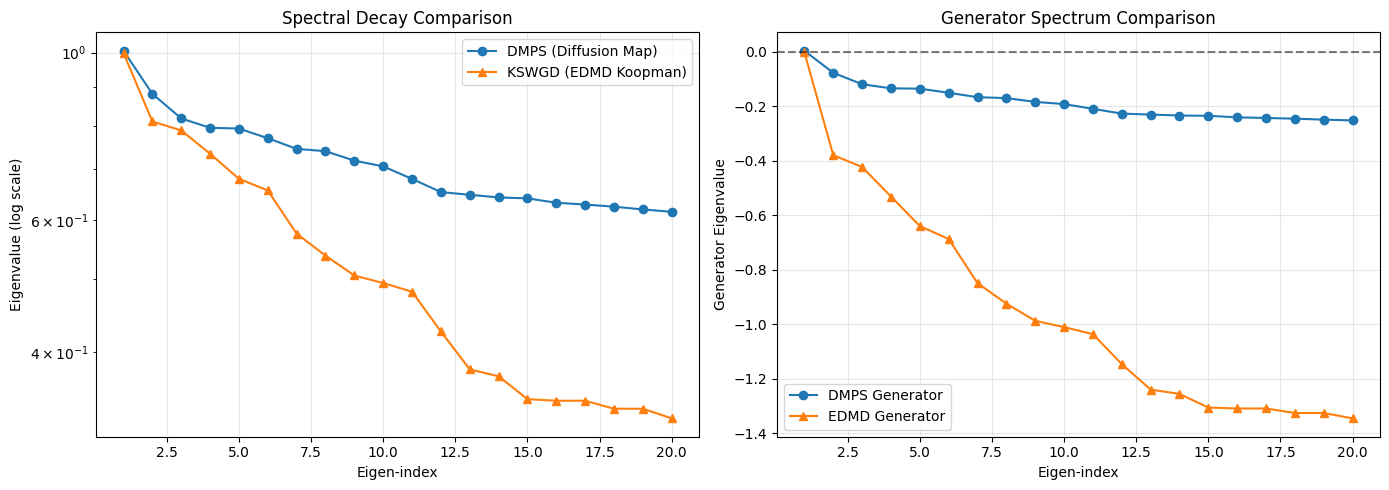


=== Method Comparison ===
DMPS: 1000 diffusion map modes
KSWGD: 256 Koopman modes from EDMD


In [17]:
# Compare Diffusion Map (DMPS) and EDMD (KSWGD) spectra
import matplotlib.pyplot as plt

n_show_eigs = 20
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Eigenvalue comparison
ax1 = axes[0]
ax1.semilogy(range(1, n_show_eigs + 1), lambda_ns[:n_show_eigs], 'o-', label="DMPS (Diffusion Map)", markersize=6)
ax1.semilogy(range(1, min(n_show_eigs, lambda_ns_edmd.size) + 1), 
             lambda_ns_edmd[:n_show_eigs], '^-', label="KSWGD (EDMD Koopman)", markersize=6)
ax1.set_xlabel("Eigen-index")
ax1.set_ylabel("Eigenvalue (log scale)")
ax1.set_title("Spectral Decay Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Generator eigenvalues
ax2 = axes[1]
lambda_gen_dmps = (lambda_ns[:n_show_eigs] - 1.0) / eps_kswgd
ax2.plot(range(1, n_show_eigs + 1), lambda_gen_dmps, 'o-', label="DMPS Generator", markersize=6)
ax2.plot(range(1, min(n_show_eigs, lambda_gen_edmd.size) + 1), 
         lambda_gen_edmd[:n_show_eigs], '^-', label="EDMD Generator", markersize=6)
ax2.set_xlabel("Eigen-index")
ax2.set_ylabel("Generator Eigenvalue")
ax2.set_title("Generator Spectrum Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
# plt.savefig("figures/dmps_vs_kswgd_spectrum.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Method Comparison ===")
print(f"DMPS: {above_tol} diffusion map modes")
print(f"KSWGD: {valid_idx_edmd.size} Koopman modes from EDMD")

In [18]:
# Define unified sampler supporting both DMPS and KSWGD (EDMD) methods
def run_particle_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=None, method="dmps"):
    """
    Unified Particle Transport Sampler
    
    Parameters:
    -----------
    method : str
        "dmps" - Diffusion Map Particle Sampling (uses diffusion map eigenvectors)
        "kswgd" - True KSWGD with EDMD Koopman operator
    rng_seed : int or None
        Random seed. If None, uses random seed for different results each run.
    """
    rng = np.random.default_rng(rng_seed)  # None gives random seed each run
    use_gpu = GPU_KSWGD and torch.cuda.is_available()
    xp = cp if use_gpu else np
    grad_fn = grad_ker1_gpu if use_gpu else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu else K_tar_eval
    
    method = method.lower()
    if method == "dmps":
        method_name = "DMPS (Diffusion Map)"
        phi_use = phi_trunc
        lambda_use = lambda_ns_s_ns
    elif method == "kswgd":
        method_name = "KSWGD (EDMD Koopman)"
        phi_use = phi_trunc_edmd
        lambda_use = lambda_ns_s_ns_edmd
    else:
        raise ValueError(f"Unknown method: {method}. Use 'dmps' or 'kswgd'.")
    
    print(f"Method: {method_name}")
    print(f"Backend: {'GPU (CuPy)' if use_gpu else 'CPU (NumPy)'}")
    print(f"Eigenfunctions shape: {phi_use.shape}")
    
    x_hist = xp.zeros((num_particles, latent_dim, num_iters), dtype=xp.float64)
    init_particles = rng.normal(0.0, 1.0, size=(num_particles, latent_dim))
    x_hist[:, :, 0] = xp.asarray(init_particles)
    
    if use_gpu:
        X_tar_dev = cp.asarray(X_tar)
        p_tar_dev = cp.asarray(p_tar)
        sq_tar_dev = cp.asarray(sq_tar)
        D_vec_dev = cp.asarray(D_vec)
        phi_dev = cp.asarray(phi_use)
        lambda_dev = cp.asarray(lambda_use)
    else:
        X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev = X_tar, p_tar, sq_tar, D_vec
        phi_dev, lambda_dev = phi_use, lambda_use
    
    iterator = trange(num_iters - 1, desc=f"{method.upper()} Transport", unit="step")
    for t in iterator:
        current = x_hist[:, :, t]
        grad_matrix = grad_fn(current, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        cross_matrix = K_eval_fn(X_tar_dev, current, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        
        tmp = (phi_dev.T @ cross_matrix) * lambda_dev[:, None]
        push = phi_dev @ tmp
        
        for dim in range(latent_dim):
            sum_term = grad_matrix[:, :, dim] @ push
            x_hist[:, dim, t + 1] = x_hist[:, dim, t] - (step_size / num_particles) * xp.sum(sum_term, axis=1)
        
        if (t + 1) % 50 == 0:
            step_norm = x_hist[:, :, t + 1] - x_hist[:, :, t]
            mean_disp = float(xp.mean(xp.linalg.norm(step_norm, axis=1)))
            iterator.set_postfix({"mean_step": f"{mean_disp:.3e}"})
            if bool(xp.any(xp.isnan(x_hist[:, :, t + 1]))):
                print(f"\nWarning: NaN detected at step {t+1}")
                return np.asarray(xp.asnumpy(x_hist[:, :, t]) if use_gpu else x_hist[:, :, t], dtype=np.float64)
    
    return np.asarray(xp.asnumpy(x_hist[:, :, -1]) if use_gpu else x_hist[:, :, -1], dtype=np.float64)


# Backward compatibility alias
def run_kswgd_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=42):
    """Legacy wrapper - uses DMPS by default for backward compatibility"""
    return run_particle_sampler(num_particles, num_iters, step_size, rng_seed, method="dmps")


def decode_latents_to_images(flat_latents_std):
    """Decode standardized latent vectors to images using MLP AutoEncoder"""
    # 1. De-standardize
    flat_latents = flat_latents_std * Z_std + Z_mean
    
    # 2. MLP AutoEncoder decode (64-dim -> 1024-dim)
    latent_ae.eval()
    with torch.no_grad():
        flat_tensor = torch.from_numpy(flat_latents).float().to(device)
        latents_recovered = latent_ae.decode(flat_tensor).cpu().numpy()
    
    # 3. Reshape to (N, 4, 16, 16)
    latents_tensor = torch.from_numpy(latents_recovered).float().view(-1, *full_latent_shape).to(device)
    
    # 4. VAE decode
    vae.eval()
    with torch.no_grad():
        decoded = vae.decode(latents_tensor / vae_scaling).sample
        decoded_rgb = _from_vae_range(decoded)
    
    return decoded_rgb.cpu()

print("Particle samplers and Decoder defined!")
print(f"  Latent compression: MLP AutoEncoder (1024 -> {REDUCED_DIM})")
print(f"  Available methods:")
print(f"    - 'dmps': Diffusion Map Particle Sampling ({above_tol} modes)")
print(f"    - 'kswgd': EDMD Koopman KSWGD ({valid_idx_edmd.size} modes)")

Particle samplers and Decoder defined!
  Latent compression: MLP AutoEncoder (1024 -> 16)
  Available methods:
    - 'dmps': Diffusion Map Particle Sampling (1000 modes)
    - 'kswgd': EDMD Koopman KSWGD (256 modes)


### 7.1 Run Generation: DMPS vs KSWGD Comparison

Now we run both methods and compare results:
- **DMPS**: Diffusion Map Particle Sampling (faster, static kernel)
- **KSWGD**: EDMD-based Koopman Spectral Wasserstein Gradient Descent (learns dynamics)

In [19]:
# ============== Spectral Memory Cleanup ==============
import gc
import sys
import torch
import psutil

print("Starting spectral memory cleanup after eigendecomposition...")

# 1. Record memory usage before cleanup
print("\n=== Memory Usage BEFORE Cleanup ===")
cpu_mem_before = psutil.virtual_memory().used / 1e9
gpu_mem_before = []
for i in range(torch.cuda.device_count()):
    gpu_allocated = torch.cuda.memory_allocated(i) / 1e9
    gpu_reserved = torch.cuda.memory_reserved(i) / 1e9
    gpu_mem_before.append((gpu_allocated, gpu_reserved))
    print(f"GPU {i}: Allocated: {gpu_allocated:.2f} GB, Reserved: {gpu_reserved:.2f} GB")
print(f"CPU RAM: {cpu_mem_before:.2f} GB")

# 2. Calculate and print sizes of variables to be deleted
print(f"\n=== Variables to be Released (max_samples = {max_samples}) ===")
memory_to_release = 0.0
variables_info = {}

# Variables that can be safely deleted after eigendecomposition
deletable_vars = [
    'dists',           # Distance matrix: (max_samples, max_samples) - huge!  
    'data_kernel',     # Original kernel matrix: (max_samples, max_samples)
    'rw_kernel',       # Random walk kernel: (max_samples, max_samples)  
    'phi',             # Full eigenvector matrix (before truncation)
    'lambda_ns',       # Full eigenvalue array (before truncation)
    'Z_flat',          # Original flattened latent vectors
    'all_latents',     # List of latent vectors
    '_eig_result',     # Temporary eigendecomposition results
]

for var in deletable_vars:
    if var in globals():
        obj = globals()[var]
        size_bytes = 0
        if hasattr(obj, 'nbytes'):
            size_bytes = obj.nbytes
        elif hasattr(obj, '__sizeof__'):
            size_bytes = obj.__sizeof__()
        elif isinstance(obj, (list, dict)):
            size_bytes = sys.getsizeof(obj)
            if isinstance(obj, list) and len(obj) > 0:
                # Estimate size for list of arrays
                if hasattr(obj[0], 'nbytes'):
                    size_bytes += sum(item.nbytes for item in obj if hasattr(item, 'nbytes'))
        
        size_gb = size_bytes / 1e9
        memory_to_release += size_gb
        variables_info[var] = size_gb
        print(f"  {var}: {size_gb:.3f} GB")

print(f"Total estimated memory to release: {memory_to_release:.2f} GB")

# 3. Ensure spectral info independence before deletion
print(f"\n=== Ensuring Spectral Data Independence ===")

# Ensure phi_trunc is independent from phi
if 'phi' in globals() and 'phi_trunc' in globals():
    if globals()['phi'] is globals()['phi_trunc']:
        print("⚠️  phi and phi_trunc are the same object - creating independent copy")
        globals()['phi_trunc'] = globals()['phi_trunc'].copy()
        print("✓ Made phi_trunc an independent copy.")
    else:
        print("✓ phi_trunc is already independent from phi")

# 4. Clear Python tracebacks (which can hold references)
sys.last_traceback = None
sys.last_value = None
sys.last_type = None

# 5. Perform the actual deletion
print(f"\n=== Deleting Large Matrices ===")
total_released = 0.0

for var in deletable_vars:
    if var in globals():
        size_gb = variables_info.get(var, 0)
        del globals()[var]
        total_released += size_gb
        print(f"✓ Deleted {var} ({size_gb:.3f} GB)")

# 6. Clean up any remaining CuPy arrays
if 'cp' in dir() and cp is not None:
    cp_vars_found = []
    for name in list(globals().keys()):
        if isinstance(globals().get(name), type(cp.ndarray(1))) if cp is not None else False:
            cp_vars_found.append(name)
            del globals()[name]
    if cp_vars_found:
        print(f"✓ Deleted CuPy arrays from globals: {', '.join(cp_vars_found)}")

# 7. Force memory release
print(f"\n=== Forcing Memory Release ===")
# Python garbage collection
for _ in range(3):
    n_collected = gc.collect()
    if n_collected > 0:
        print(f"✓ Python GC collected {n_collected} objects")

# CuPy memory pool cleanup
if 'cp' in dir() and cp is not None:
    try:
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()
        
        for _ in range(3):
            mempool.free_all_blocks()
            pinned_mempool.free_all_blocks()
        
        print(f"✓ CuPy memory pool cleared and blocks freed.")
    except Exception as e:
        print(f"✗ CuPy cleanup error: {e}")

# PyTorch cleanup
torch.cuda.empty_cache()
print("✓ PyTorch CUDA cache emptied")

# 8. Record memory usage after cleanup  
print(f"\n=== Memory Usage AFTER Cleanup ===")
cpu_mem_after = psutil.virtual_memory().used / 1e9
gpu_mem_after = []
for i in range(torch.cuda.device_count()):
    gpu_allocated = torch.cuda.memory_allocated(i) / 1e9
    gpu_reserved = torch.cuda.memory_reserved(i) / 1e9
    gpu_mem_after.append((gpu_allocated, gpu_reserved))
    total = torch.cuda.get_device_properties(i).total_memory / 1e9
    print(f"GPU {i}: Allocated: {gpu_allocated:.2f} GB, Reserved: {gpu_reserved:.2f} GB, Free: {total - gpu_allocated:.2f} GB")
print(f"CPU RAM: {cpu_mem_after:.2f} GB")

# 9. Calculate and report memory savings
print(f"\n=== Memory Cleanup Summary ===")
cpu_released = cpu_mem_before - cpu_mem_after
print(f"CPU RAM released: {cpu_released:.2f} GB")

for i in range(len(gpu_mem_before)):
    gpu_released_allocated = gpu_mem_before[i][0] - gpu_mem_after[i][0]  
    gpu_released_reserved = gpu_mem_before[i][1] - gpu_mem_after[i][1]
    print(f"GPU {i} memory released: Allocated: {gpu_released_allocated:.2f} GB, Reserved: {gpu_released_reserved:.2f} GB")

print(f"Estimated variables released: {total_released:.2f} GB")

# 10. Verify essential spectral data is preserved
print(f"\n=== Essential Spectral Data Verification ===")
essential_vars = [
    'phi_trunc',        # Truncated eigenvectors (n_samples, above_tol)
    'lambda_ns_s_ns',   # Processed eigenvalue weights (above_tol,)
    'X_tar',            # Standardized target samples (n_samples, latent_dim)
    'p_tar',            # Target distribution weights (n_samples,)
    'sq_tar',           # Squared sums of target samples (n_samples,) 
    'D_vec',            # Normalization vector (n_samples,)
    'eps_kswgd',        # Kernel bandwidth parameter
    'Z_mean',           # Standardization mean
    'Z_std',            # Standardization std
]

all_essential_ok = True
for var in essential_vars:
    if var in globals():
        obj = globals()[var]
        if hasattr(obj, 'shape'):
            print(f"✓ {var}: shape {obj.shape}, dtype {obj.dtype}")
        else:
            print(f"✓ {var}: {type(obj).__name__} = {obj}")
    else:
        print(f"✗ {var}: MISSING!")
        all_essential_ok = False

if all_essential_ok:
    print(f"\n✅ All essential spectral data preserved! KSWGD sampling can proceed.")
else:
    print(f"\n❌ Some essential data is missing! Check before running KSWGD.")

print(f"\n✅ Spectral memory cleanup complete!")
print(f"   Total estimated release: {total_released:.2f} GB")
print(f"   Kernel matrix ({max_samples}x{max_samples}) and full eigenvectors deleted")
print(f"   Truncated spectral info (k_eig={k_eig}) preserved for KSWGD")

Starting spectral memory cleanup after eigendecomposition...

=== Memory Usage BEFORE Cleanup ===
GPU 0: Allocated: 0.91 GB, Reserved: 0.99 GB
CPU RAM: 210.21 GB

=== Variables to be Released (max_samples = 28000) ===
  dists: 6.272 GB
  data_kernel: 6.272 GB
  rw_kernel: 6.272 GB
  phi: 0.112 GB
  lambda_ns: 0.000 GB
  _eig_result: 0.000 GB
Total estimated memory to release: 18.93 GB

=== Ensuring Spectral Data Independence ===
✓ phi_trunc is already independent from phi

=== Deleting Large Matrices ===
✓ Deleted dists (6.272 GB)
✓ Deleted data_kernel (6.272 GB)
✓ Deleted rw_kernel (6.272 GB)
✓ Deleted phi (0.112 GB)
✓ Deleted lambda_ns (0.000 GB)
✓ Deleted _eig_result (0.000 GB)

=== Forcing Memory Release ===
✓ Python GC collected 22795 objects
✓ CuPy memory pool cleared and blocks freed.
✓ PyTorch CUDA cache emptied

=== Memory Usage AFTER Cleanup ===
GPU 0: Allocated: 0.91 GB, Reserved: 0.99 GB, Free: 84.19 GB
CPU RAM: 191.51 GB

=== Memory Cleanup Summary ===
CPU RAM released: 18

In [20]:
# Run KSWGD sampling to generate new latent vectors
kswgd_config = {
    "num_particles": 16,  # (n_generate) Same as LDM generation count for fair comparison
    "num_iters": 300,             # Number of iterations
    "step_size": 0.01,            # Step size (smaller for stability)
    # "rng_seed": 42
}

print("=" * 50)
print("KSWGD Generation Config:")
for k, v in kswgd_config.items():
    print(f"  {k}: {v}")
print("=" * 50)
print(f"\nNote: Generating {kswgd_config['num_particles']} particles for reliable FID...")
print("This will take a while...")

# Run KSWGD (progress bar is built into run_kswgd_sampler via trange)
start_time = time.time()
Z_kswgd_std = run_kswgd_sampler(**kswgd_config)
kswgd_time = time.time() - start_time

print(f"\n✓ KSWGD Complete!")
print(f"Generated samples shape: {Z_kswgd_std.shape}")
print(f"Total time: {kswgd_time:.1f} seconds ({kswgd_time/60:.1f} minutes)")

KSWGD Generation Config:
  num_particles: 16
  num_iters: 300
  step_size: 0.01

Note: Generating 16 particles for reliable FID...
This will take a while...
Method: DMPS (Diffusion Map)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 1000)


DMPS Transport: 100%|██████████| 299/299 [00:02<00:00, 140.34step/s, mean_step=0.000e+00]


✓ KSWGD Complete!
Generated samples shape: (16, 16)
Total time: 2.5 seconds (0.0 minutes)


In [21]:
# Move models to GPU for decoding
import torch
import numpy as np
from tqdm.auto import tqdm

decode_device = torch.device("cuda")
print(f"Moving models to {decode_device}...")
vae = vae.to(decode_device)
latent_ae = latent_ae.to(decode_device)
print(f"✓ Models (VAE, MLP AutoEncoder) moved to {decode_device}")

# Redefine helper to ensure it uses the correct device
def decode_latents_to_images_safe(flat_latents_std, target_device):
    """Decode standardized latent vectors to images using MLP AutoEncoder"""
    # 1. De-standardize
    # Ensure Z_std and Z_mean are available
    if 'Z_std' not in globals() or 'Z_mean' not in globals():
        raise ValueError("Z_std or Z_mean not found in globals. Please run the standardization cell first.")
        
    flat_latents = flat_latents_std * Z_std + Z_mean
    
    # 2. MLP AutoEncoder decode (64-dim -> 1024-dim)
    latent_ae.eval()
    with torch.no_grad():
        flat_tensor = torch.from_numpy(flat_latents).float().to(target_device)
        latents_recovered = latent_ae.decode(flat_tensor).cpu().numpy()
    
    # 3. Reshape to (N, 4, 16, 16)
    # Ensure full_latent_shape is available
    shape = full_latent_shape if 'full_latent_shape' in globals() else (4, 16, 16)
    latents_tensor = torch.from_numpy(latents_recovered).float().view(-1, *shape).to(target_device)
    
    # 4. VAE decode
    vae.eval()
    with torch.no_grad():
        # Ensure vae_scaling is available
        scaling = vae_scaling if 'vae_scaling' in globals() else 1.0
        decoded = vae.decode(latents_tensor / scaling).sample
        
        # Ensure _from_vae_range is available
        if '_from_vae_range' in globals():
            decoded_rgb = _from_vae_range(decoded)
        else:
            decoded_rgb = torch.clamp((decoded + 1.0) * 0.5, 0.0, 1.0)
    
    return decoded_rgb.cpu()

# Decode KSWGD generated latent vectors to images (in batches to avoid OOM)
if 'Z_kswgd_std' in globals():
    print(f"Decoding {Z_kswgd_std.shape[0]} latent vectors to images...")
    
    decode_batch_size = 128  # Increased for 80GB GPUs
    all_kswgd_images = []
    
    for i in tqdm(range(0, Z_kswgd_std.shape[0], decode_batch_size), desc="Decoding KSWGD"):
        batch_latents = Z_kswgd_std[i:i+decode_batch_size]
        
        # Use the safe local function with explicit device
        batch_images = decode_latents_to_images_safe(batch_latents, decode_device)
        all_kswgd_images.append(batch_images.numpy())
        
        # Clear cache periodically
        if (i // decode_batch_size + 1) % 20 == 0:
            torch.cuda.empty_cache()
    
    kswgd_images_np = np.concatenate(all_kswgd_images, axis=0)
    
    print(f"\n✓ Decoding complete!")
    print(f"Generated images shape: {kswgd_images_np.shape}")
    print(f"Pixel value range: [{kswgd_images_np.min():.3f}, {kswgd_images_np.max():.3f}]")
else:
    print("⚠️ Z_kswgd_std not found. Please run KSWGD sampling first.")

Moving models to cuda...
✓ Models (VAE, MLP AutoEncoder) moved to cuda
Decoding 16 latent vectors to images...


Decoding KSWGD: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


✓ Decoding complete!
Generated images shape: (16, 3, 256, 256)
Pixel value range: [0.000, 0.999]


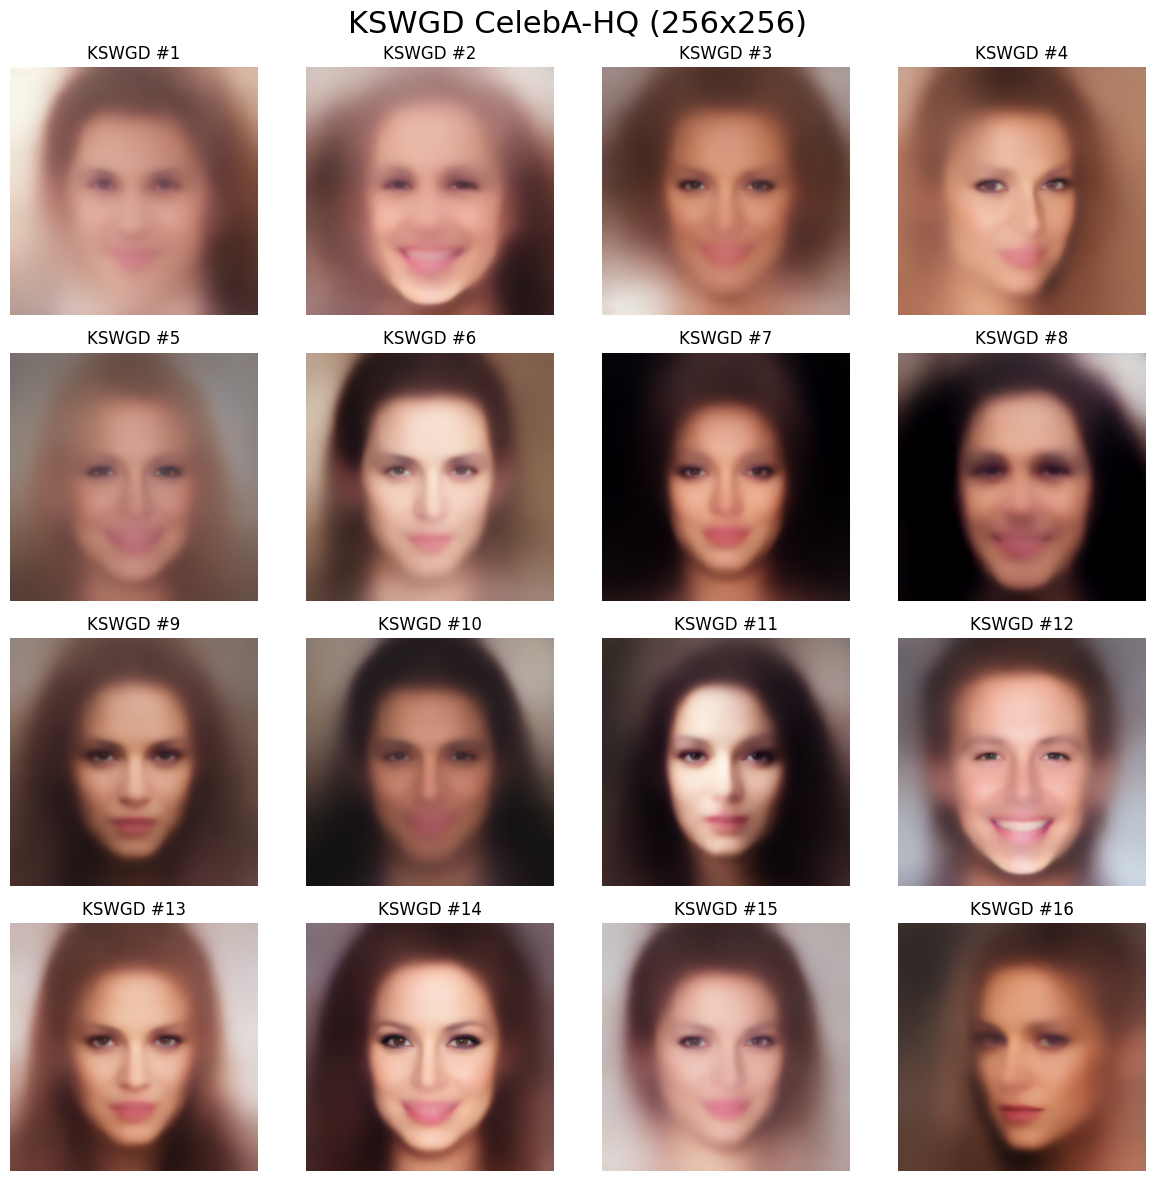


Generation Summary:
  - KSWGD: 16 images via KSWGD (300 steps)


In [22]:
# Visualize KSWGD generated images (show first 16 of 10000)
n_show = min(16, kswgd_images_np.shape[0])
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = np.asarray(axes).reshape(-1)

for idx in range(n_show):
    img = np.transpose(kswgd_images_np[idx], (1, 2, 0))  # (C,H,W) → (H,W,C)
    axes[idx].imshow(np.clip(img, 0.0, 1.0))
    axes[idx].set_title(f"KSWGD #{idx+1}")
    axes[idx].axis('off')

for idx in range(n_show, len(axes)):
    axes[idx].axis('off')

# Get image size from KSWGD generated images (shape is N, C, H, W)
_kswgd_img_size = kswgd_images_np.shape[2]
plt.suptitle(f"KSWGD CelebA-HQ ({_kswgd_img_size}x{_kswgd_img_size})", fontsize=22)
plt.tight_layout()
plt.show()

print(f"\nGeneration Summary:")
# print(f"  - LDM: {len(ldm_generated_images)} images via UNet Denoising (200 steps)")
print(f"  - KSWGD: {kswgd_images_np.shape[0]} images via KSWGD ({kswgd_config['num_iters']} steps)")

Upscaling KSWGD Generated Images with GFPGAN
(with preprocessing: Gaussian + Bilateral + Color Norm)

Enhancing 16 KSWGD images with preprocessing + GFPGAN...


Preprocess+GFPGAN (KSWGD):   0%|          | 0/16 [00:00<?, ?it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):   6%|▋         | 1/16 [00:00<00:09,  1.63it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  12%|█▎        | 2/16 [00:01<00:07,  1.88it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  19%|█▉        | 3/16 [00:01<00:06,  2.15it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  25%|██▌       | 4/16 [00:01<00:05,  2.28it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  31%|███▏      | 5/16 [00:02<00:04,  2.36it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  38%|███▊      | 6/16 [00:02<00:04,  2.40it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  44%|████▍     | 7/16 [00:03<00:03,  2.42it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  50%|█████     | 8/16 [00:03<00:03,  2.47it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  56%|█████▋    | 9/16 [00:03<00:02,  2.46it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  62%|██████▎   | 10/16 [00:04<00:02,  2.48it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  69%|██████▉   | 11/16 [00:04<00:02,  2.48it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  75%|███████▌  | 12/16 [00:05<00:01,  2.51it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  81%|████████▏ | 13/16 [00:05<00:01,  2.47it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  88%|████████▊ | 14/16 [00:05<00:00,  2.50it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD):  94%|█████████▍| 15/16 [00:06<00:00,  2.51it/s]

	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


Preprocess+GFPGAN (KSWGD): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


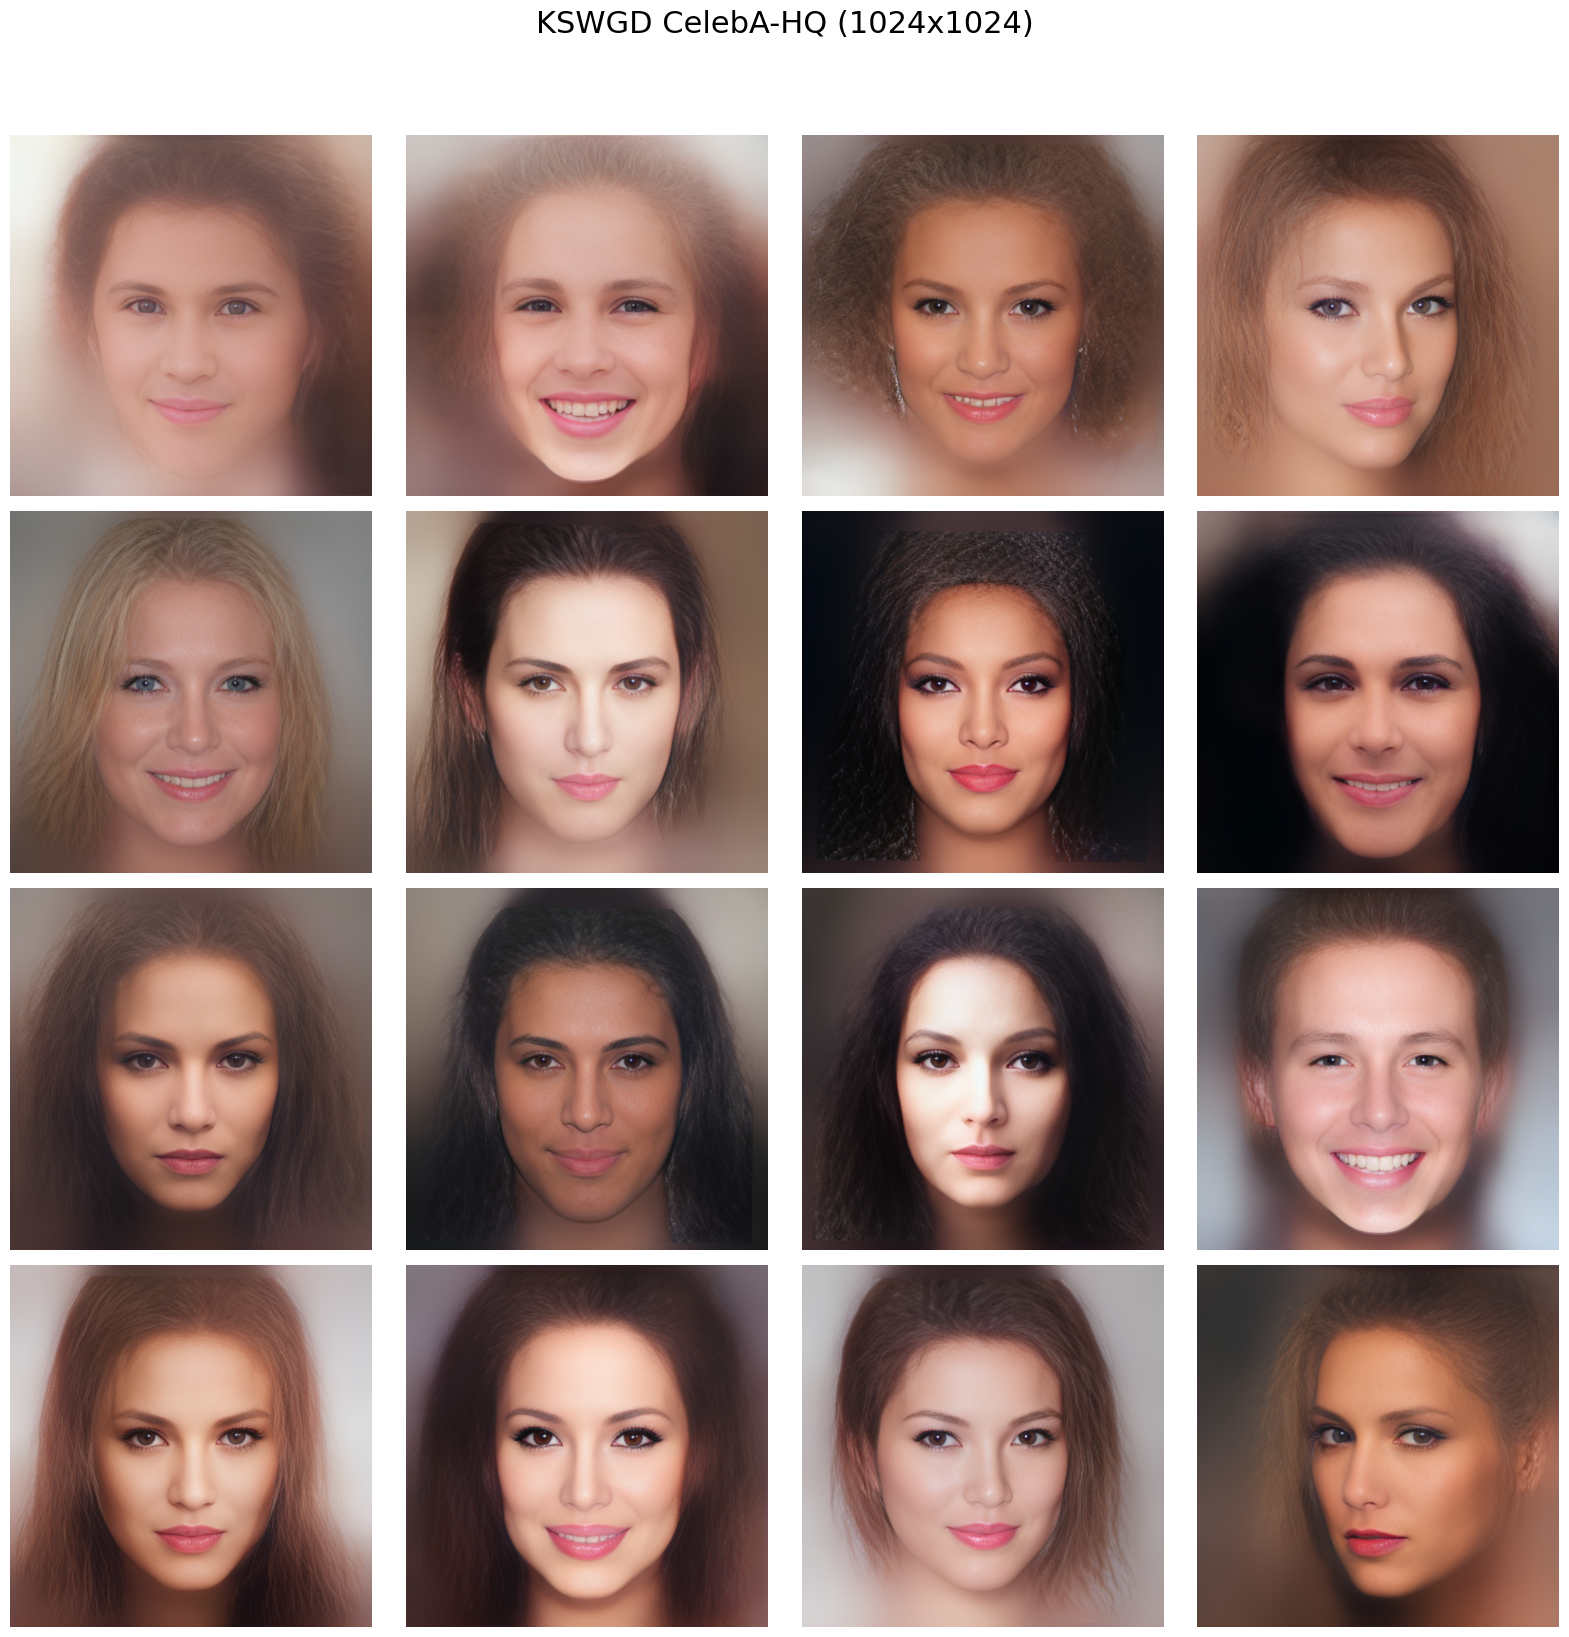


✓ KSWGD Enhancement complete!
  Original KSWGD: 256x256
  Enhanced: 1024x1024
  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)


In [23]:
# ============== Apply GFPGAN to KSWGD Generated Images ==============
print("=" * 60)
print("Upscaling KSWGD Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

# Convert KSWGD images to the right format for upscaling
kswgd_images_for_upscale = []
for i in range(kswgd_images_np.shape[0]):
    img = np.transpose(kswgd_images_np[i], (1, 2, 0))  # (C,H,W) → (H,W,C)
    img = np.clip(img, 0, 1)
    kswgd_images_for_upscale.append(img)

print(f"\nEnhancing {len(kswgd_images_for_upscale)} KSWGD images with preprocessing + GFPGAN...")
kswgd_enhanced = upscale_images(kswgd_images_for_upscale, use_face_enhance=True, use_preprocess=True, desc="Preprocess+GFPGAN (KSWGD)")

# Visualization (show up to 16 in a grid)
n_test_kswgd = len(kswgd_enhanced)
n_show_kswgd = min(16, n_test_kswgd)
n_cols = 4
n_rows = (n_show_kswgd + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show_kswgd):
    axes[i].imshow(kswgd_enhanced[i])
    # axes[i].set_title(f"#{i+1}")
    axes[i].axis('off')

for i in range(n_show_kswgd, len(axes)):
    axes[i].axis('off')

# Get image size from enhanced images
_kswgd_enhanced_size = kswgd_enhanced[0].shape[1] if isinstance(kswgd_enhanced[0], np.ndarray) else kswgd_enhanced[0].size[0]
plt.suptitle(f"KSWGD CelebA-HQ ({_kswgd_enhanced_size}x{_kswgd_enhanced_size})\n", fontsize=22, y=1.02)
plt.tight_layout()
# plt.savefig('/workspace/kswgd/figures/kswgd_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Store enhanced KSWGD images
kswgd_upscaled = kswgd_enhanced

print(f"\n✓ KSWGD Enhancement complete!")
print(f"  Original KSWGD: 256x256")
print(f"  Enhanced: {kswgd_upscaled[0].shape[1]}x{kswgd_upscaled[0].shape[0]}")
print(f"  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)")

### 7.2 KSWGD FID Evaluation & Memory Cleanup

Compute FID scores for KSWGD generated images **immediately after generation**, then clean up to free memory for LDM.

In [24]:
# ============== FID Utility Functions ==============
# Install pytorch-fid if needed
import subprocess
import sys
import random

try:
    from pytorch_fid import fid_score
    from pytorch_fid.inception import InceptionV3
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-fid", "-q"])
    from pytorch_fid import fid_score
    from pytorch_fid.inception import InceptionV3

from scipy import linalg
from torchvision import transforms as T

print("FID computation: Using single GPU mode")

def load_real_images_for_fid(dataset, n_samples, size=256, desc="Loading"):
    """Load real images from dataset for FID computation"""
    images = []
    indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor()
    ])
    
    for idx in tqdm(indices, desc=desc):
        img = dataset[idx]['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = transform(img)
        images.append(img)
    
    return torch.stack(images)

def get_inception_features(images, batch_size=256, desc="Extracting features"):
    """Extract Inception-v3 features
    
    Args:
        images: Can be:
            - torch.Tensor with shape (N, C, H, W) - values in [0, 1]
            - np.ndarray with shape (N, C, H, W) - values in [0, 1]
            - np.ndarray with shape (N, H, W, C) - values in [0, 1] or [0, 255]
            - list of np.ndarray with shape (H, W, C)
    """
    device = torch.device("cuda")

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    inception = InceptionV3([block_idx]).to(device)
    inception.eval()

    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    features = []
    
    # Handle list of images
    if isinstance(images, list):
        images = np.stack(images)
    
    n_batches = (len(images) + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in tqdm(range(n_batches), desc=desc):
            batch = images[i*batch_size:(i+1)*batch_size]
            
            # Convert to torch tensor if needed
            if isinstance(batch, np.ndarray):
                batch = torch.from_numpy(batch).float()
            
            # Check shape and permute if needed
            # We need (N, C, H, W) format where C=3
            if batch.dim() == 4:
                # If shape is (N, H, W, C) where last dim is 3, permute to (N, C, H, W)
                if batch.shape[-1] == 3 and batch.shape[1] != 3:
                    batch = batch.permute(0, 3, 1, 2)
                # If shape is already (N, C, H, W), no change needed
            elif batch.dim() == 3:
                # Single image (H, W, C) or (C, H, W)
                if batch.shape[-1] == 3:
                    batch = batch.permute(2, 0, 1).unsqueeze(0)
                else:
                    batch = batch.unsqueeze(0)
            
            batch = batch.to(device)
            
            # Normalize to [0, 1] if values are in [0, 255]
            if batch.max() > 1.0:
                batch = batch / 255.0
            
            batch = preprocess(batch)
            feat = inception(batch)[0]
            feat = feat.squeeze(-1).squeeze(-1)
            features.append(feat.cpu().numpy())

    del inception
    torch.cuda.empty_cache()
    return np.vstack(features)

def calculate_fid_from_features(feat1, feat2):
    """Calculate FID from pre-extracted features"""
    mu1, sigma1 = feat1.mean(axis=0), np.cov(feat1, rowvar=False)
    mu2, sigma2 = feat2.mean(axis=0), np.cov(feat2, rowvar=False)
    
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return float(fid)

def compute_fid(images1, images2, batch_size=256):
    """Compute FID between two sets of images"""
    print(f"Computing FID between {len(images1)} and {len(images2)} images...")
    
    feat1 = get_inception_features(images1, batch_size, desc="Features (Set 1)")
    feat2 = get_inception_features(images2, batch_size, desc="Features (Set 2)")
    
    return calculate_fid_from_features(feat1, feat2)

print("✓ FID utility functions loaded")

FID computation: Using single GPU mode
✓ FID utility functions loaded


In [ ]:
# ============== KSWGD FID Evaluation (Raw 256x256 + Enhanced 1024x1024) ==============
import gc

print("=" * 60)
print("Computing FID Scores for KSWGD Generated Images...")
print(f"  KSWGD raw (256): {len(kswgd_images_np)} images")
print(f"  KSWGD enhanced (1024): {len(kswgd_upscaled)} images")
print("=" * 60)

# 1. Load real images for FID (256x256)
n_real_samples = min(10000, len(celebahq_dataset))
print(f"\n[1/5] Loading real CelebA-HQ images (256x256)...")
real_images_256 = load_real_images_for_fid(celebahq_dataset, n_real_samples, size=256, desc="Real images (256)")
print(f"  Real images loaded: {len(real_images_256)}")

# 2. Extract features for 256x256
print("\n[2/5] Extracting Inception features from real images (256)...")
real_features_256 = get_inception_features(real_images_256, desc="Real (256)")
print("Computing FID Scores for KSWGD Generated Images...")
print(f"  KSWGD raw (256): {len(kswgd_images_np)} images")
print(f"  KSWGD enhanced (1024): {len(kswgd_upscaled)} images")
print("=" * 60)

# 1. Load real images for FID (256x256)
n_real_samples = min(10000, len(celebahq_dataset))
print(f"\n[1/5] Loading real CelebA-HQ images (256x256)...")
real_images_256 = load_real_images_for_fid(celebahq_dataset, n_real_samples, size=256, desc="Real images (256)")
print(f"  Real images loaded: {len(real_images_256)}")

# 2. Extract features for 256x256
print("\n[2/5] Extracting Inception features from real images (256)...")
real_features_256 = get_inception_features(real_images_256, desc="Real (256)")

print("\n[3/5] Extracting Inception features from KSWGD raw images (256)...")
kswgd_features_256 = get_inception_features(kswgd_images_np, desc="KSWGD Raw (256)")

# 3. Calculate KSWGD raw FID (from pre-extracted features)
fid_kswgd_raw = calculate_fid_from_features(real_features_256, kswgd_features_256)
print(f"\n✓ KSWGD Raw (256x256) FID = {fid_kswgd_raw:.2f}")

# 4. Clean up 256x256 real images to free memory
del real_images_256
gc.collect()
print("  (256x256 real images cleaned up)")

# 5. Load real images for FID (1024x1024)
print(f"\n[4/5] Loading real CelebA-HQ images (1024x1024)...")
real_images_1024 = load_real_images_for_fid(celebahq_dataset, n_real_samples, size=1024, desc="Real images (1024)")
print(f"  Real images loaded: {len(real_images_1024)}")

# 6. Extract features for 1024x1024
print("\n[5/5] Extracting Inception features...")
real_features_1024 = get_inception_features(real_images_1024, desc="Real (1024)")
kswgd_features_1024 = get_inception_features(kswgd_upscaled, desc="KSWGD Enhanced (1024)")

# 7. Calculate KSWGD enhanced FID (from pre-extracted features)
fid_kswgd_enhanced = calculate_fid_from_features(real_features_1024, kswgd_features_1024)
print(f"\n✓ KSWGD Enhanced (1024x1024) FID = {fid_kswgd_enhanced:.2f}")

# 8. Print KSWGD FID Summary
print("\n" + "=" * 60)
print("KSWGD FID RESULTS (Lower is Better)")
print("=" * 60)
print(f"  Real images:          {n_real_samples}")
print(f"  KSWGD (Raw 256):      {len(kswgd_images_np)} → FID = {fid_kswgd_raw:.2f}")
print(f"  KSWGD (Enhanced 1024): {len(kswgd_upscaled)} → FID = {fid_kswgd_enhanced:.2f}")
print("=" * 60)

In [ ]:
# ============== KSWGD Memory Cleanup ==============
import gc
import psutil

print("=" * 60)
print("KSWGD Memory Cleanup")
print("=" * 60)

# Record memory before cleanup
cpu_before = psutil.virtual_memory().used / 1e9
gpu_before = [torch.cuda.memory_allocated(i) / 1e9 for i in range(torch.cuda.device_count())]

# Variables to clean up after KSWGD FID is computed
# Keep: real_features_1024, real_features_256 (for LDM comparison)
# Keep: fid_kswgd_raw, fid_kswgd_enhanced (results)
kswgd_cleanup_vars = [
    'kswgd_images_np',       # Raw KSWGD images (750 MB)
    'kswgd_images_for_upscale',  # Images prepared for upscale
    'all_kswgd_images',      # Decoded images list
    'kswgd_upscaled',        # Enhanced images (3 GB)
    'kswgd_enhanced',        # Enhanced images copy
    'kswgd_features_256',    # Features (can recompute if needed)
    'kswgd_features_1024',   # Features (can recompute if needed)
    'Z_kswgd_std',           # KSWGD latent vectors
    'real_images_1024',      # Real images (120 GB!) - will reload for LDM
]

deleted_vars = []
for var in kswgd_cleanup_vars:
    if var in globals():
        size_mb = 0
        obj = globals()[var]
        if hasattr(obj, 'nbytes'):
            size_mb = obj.nbytes / 1e6
        elif isinstance(obj, list) and len(obj) > 0:
            if hasattr(obj[0], 'nbytes'):
                size_mb = sum(x.nbytes for x in obj if hasattr(x, 'nbytes')) / 1e6
            elif hasattr(obj[0], 'shape'):
                size_mb = sum(x.nbytes if hasattr(x, 'nbytes') else 0 for x in obj) / 1e6
        del globals()[var]
        deleted_vars.append(f"{var} ({size_mb:.1f} MB)")

# Force garbage collection
for _ in range(3):
    gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

# CuPy cleanup if available
if 'cp' in dir() and cp is not None:
    try:
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
    except:
        pass

# Record memory after cleanup
cpu_after = psutil.virtual_memory().used / 1e9
gpu_after = [torch.cuda.memory_allocated(i) / 1e9 for i in range(torch.cuda.device_count())]

print(f"\nDeleted variables:")
for v in deleted_vars:
    print(f"  ✓ {v}")

print(f"\nMemory Released:")
print(f"  CPU RAM: {cpu_before - cpu_after:.2f} GB")
for i in range(len(gpu_before)):
    print(f"  GPU {i}: {gpu_before[i] - gpu_after[i]:.2f} GB")

print(f"\nCurrent Memory Usage:")
print(f"  CPU RAM: {cpu_after:.2f} GB")
for i in range(torch.cuda.device_count()):
    alloc = torch.cuda.memory_allocated(i) / 1e9
    total = torch.cuda.get_device_properties(i).total_memory / 1e9
    print(f"  GPU {i}: {alloc:.2f} GB / {total:.2f} GB")

print(f"\n✅ KSWGD cleanup complete! Ready for LDM generation.")

### 7.3 LDM Generation, Enhancement & FID Evaluation

Now that KSWGD is complete and memory is freed, we generate LDM images, enhance them, compute FID, and clean up.

In [ ]:
# ============== LDM Generation (After KSWGD) ==============
import time
import torch
from tqdm.auto import tqdm
from diffusers import DiffusionPipeline

# Configuration
if 'kswgd_config' in globals():
    n_generate = kswgd_config.get('num_particles', 16)
    print(f"Using n_generate = {n_generate} (matched with KSWGD)")
else:
    n_generate = 16  # Default if KSWGD not run
    print(f"Using default n_generate = {n_generate}")

batch_size = 64    # Batch size for 80GB GPUs

print("=" * 60)
print("LDM Generation (After KSWGD)")
print("=" * 60)
print(f"Generating {n_generate} unconditional LDM images...")

# Check if LDM pipeline exists and is valid, reload if needed
should_reload = False
if 'ldm_pipe' not in globals():
    should_reload = True
else:
    if not hasattr(ldm_pipe, 'unet') or ldm_pipe.unet is None:
        print("⚠️ LDM pipeline found but appears corrupted. Reloading...")
        should_reload = True

if should_reload:
    print("Loading LDM pipeline...")
    ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
    ldm_pipe = ldm_pipe.to("cuda")
    ldm_pipe.vqvae.config.scaling_factor = 1.0
else:
    print("Using existing LDM pipeline...")
    ldm_pipe = ldm_pipe.to("cuda")
    ldm_pipe.vqvae.config.scaling_factor = 1.0

print("Using single GPU mode")

start_time = time.time()
ldm_images = []
n_batches = (n_generate + batch_size - 1) // batch_size

for batch_idx in tqdm(range(n_batches), desc="LDM Generation"):
    current_batch_size = min(batch_size, n_generate - batch_idx * batch_size)
    output = ldm_pipe(
        batch_size=current_batch_size,
        num_inference_steps=200,
        output_type="pil"
    )
    ldm_images.extend(output.images)

ldm_time = time.time() - start_time

# Create alias for consistency with later cells
ldm_generated_images = ldm_images


print(f"\n✓ Generated {len(ldm_images)} LDM images in {ldm_time:.2f}s ({ldm_time/len(ldm_images):.2f}s/img)")

In [ ]:
# ============== LDM Enhancement with GFPGAN ==============
print("=" * 60)
print("Enhancing LDM Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

n_test = len(ldm_generated_images)
print(f"\nEnhancing {n_test} LDM images...")
ldm_enhanced = upscale_images(ldm_generated_images, use_face_enhance=True, use_preprocess=True, desc="LDM GFPGAN")
ldm_upscaled = ldm_enhanced

# Visualization
n_show = min(16, n_test)
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show):
    axes[i].imshow(ldm_enhanced[i])
    axes[i].axis('off')

for i in range(n_show, len(axes)):
    axes[i].axis('off')

_ldm_enhanced_size = ldm_enhanced[0].shape[1] if isinstance(ldm_enhanced[0], np.ndarray) else ldm_enhanced[0].size[0]
plt.suptitle(f"LDM Enhanced ({_ldm_enhanced_size}x{_ldm_enhanced_size})", fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('/workspace/kswgd/figures/ldm_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ LDM Enhancement complete!")
print(f"  Original: 256x256 → Enhanced: {ldm_upscaled[0].shape[1]}x{ldm_upscaled[0].shape[0]}")

In [ ]:
# ============== LDM FID Evaluation ==============
import gc

print("=" * 60)
print("Computing FID Scores for LDM Generated Images...")
print(f"  LDM raw (256): {len(ldm_generated_images)} images")
print(f"  LDM enhanced (1024): {len(ldm_upscaled)} images")
print("=" * 60)

# 1. Load real images for FID (256x256)
n_real_samples = min(10000, len(celebahq_dataset))
print(f"\n[1/5] Loading real CelebA-HQ images (256x256)...")
real_images_256 = load_real_images_for_fid(celebahq_dataset, n_real_samples, size=256, desc="Real images (256)")
print(f"  Real images loaded: {len(real_images_256)}")

# 2. Extract features for 256x256
print("\n[2/5] Extracting Inception features from real images (256)...")
real_features_256 = get_inception_features(real_images_256, desc="Real (256)")

print("\n[3/5] Extracting Inception features from LDM raw images (256)...")
ldm_features_256 = get_inception_features(ldm_generated_images, desc="LDM Raw (256)")

# 3. Calculate LDM raw FID (use calculate_fid_from_features since we have features)
fid_ldm_raw = calculate_fid_from_features(real_features_256, ldm_features_256)
print(f"\n✓ LDM Raw (256x256) FID = {fid_ldm_raw:.2f}")

# 4. Clean up 256x256 real images
del real_images_256
gc.collect()
print("  (256x256 real images cleaned up)")

# 5. Load real images for FID (1024x1024)
print(f"\n[4/5] Loading real CelebA-HQ images (1024x1024)...")
real_images_1024 = load_real_images_for_fid(celebahq_dataset, n_real_samples, size=1024, desc="Real images (1024)")
print(f"  Real images loaded: {len(real_images_1024)}")

# 6. Extract features for 1024x1024
print("\n[5/5] Extracting Inception features...")
real_features_1024 = get_inception_features(real_images_1024, desc="Real (1024)")
ldm_features_1024 = get_inception_features(ldm_upscaled, desc="LDM Enhanced (1024)")

# 7. Calculate LDM enhanced FID (use calculate_fid_from_features since we have features)
fid_ldm_enhanced = calculate_fid_from_features(real_features_1024, ldm_features_1024)
print(f"\n✓ LDM Enhanced (1024x1024) FID = {fid_ldm_enhanced:.2f}")

# 8. Print LDM FID Summary
print("\n" + "=" * 60)
print("LDM FID RESULTS (Lower is Better)")
print("=" * 60)
print(f"  Real images:         {n_real_samples}")
print(f"  LDM (Raw 256):      {len(ldm_generated_images)} → FID = {fid_ldm_raw:.2f}")
print(f"  LDM (Enhanced 1024): {len(ldm_upscaled)} → FID = {fid_ldm_enhanced:.2f}")
print("=" * 60)

In [ ]:
# ============== LDM Memory Cleanup & Final Summary ==============
import gc
import psutil

print("=" * 60)
print("LDM Memory Cleanup & Final Summary")
print("=" * 60)

# Memory cleanup
cpu_before = psutil.virtual_memory().used / 1e9

ldm_cleanup_vars = [
    'ldm_generated_images',  # Raw LDM images
    'ldm_upscaled',          # Enhanced images
    'ldm_enhanced',          # Enhanced images copy
    'ldm_features_256',      # Features
    'ldm_features_1024',     # Features
    'real_images_1024',      # Real images (120 GB!)
    'real_features_256',     # Features
    'real_features_1024',    # Features
]

deleted_vars = []
for var in ldm_cleanup_vars:
    if var in globals():
        del globals()[var]
        deleted_vars.append(var)

for _ in range(3):
    gc.collect()
torch.cuda.empty_cache()

cpu_after = psutil.virtual_memory().used / 1e9

print(f"\nDeleted: {', '.join(deleted_vars)}")
print(f"CPU RAM released: {cpu_before - cpu_after:.2f} GB")

# ============== FINAL FID COMPARISON ==============
print("\n" + "=" * 70)
print("                    FINAL FID COMPARISON RESULTS")
print("=" * 70)
print(f"{'Method':<25} {'Resolution':<15} {'Samples':<10} {'FID ↓':<10}")
print("-" * 70)

# Check if FID results exist
if 'fid_kswgd_raw' in globals():
    print(f"{'KSWGD':<25} {'256x256':<15} {kswgd_config['num_particles']:<10} {fid_kswgd_raw:.2f}")
if 'fid_kswgd_enhanced' in globals():
    print(f"{'KSWGD + GFPGAN':<25} {'1024x1024':<15} {kswgd_config['num_particles']:<10} {fid_kswgd_enhanced:.2f}")
if 'fid_ldm_raw' in globals():
    print(f"{'LDM':<25} {'256x256':<15} {n_generate:<10} {fid_ldm_raw:.2f}")
if 'fid_ldm_enhanced' in globals():
    print(f"{'LDM + GFPGAN':<25} {'1024x1024':<15} {n_generate:<10} {fid_ldm_enhanced:.2f}")

print("=" * 70)

# Determine winner
if 'fid_kswgd_raw' in globals() and 'fid_ldm_raw' in globals():
    print("\n📊 Analysis:")
    print(f"  Raw 256x256:      {'KSWGD' if fid_kswgd_raw < fid_ldm_raw else 'LDM'} wins by {abs(fid_kswgd_raw - fid_ldm_raw):.2f}")
if 'fid_kswgd_enhanced' in globals() and 'fid_ldm_enhanced' in globals():
    print(f"  Enhanced 1024x1024: {'KSWGD' if fid_kswgd_enhanced < fid_ldm_enhanced else 'LDM'} wins by {abs(fid_kswgd_enhanced - fid_ldm_enhanced):.2f}")

print("\n✅ All evaluations complete!")